In [3]:
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [11]:
%%R
c <- c(1,2)
c

[1] 1 2


In [1]:
import pandas as pd
from __future__ import division
import math
import datetime
import numpy as np
import scipy as sc
import pylab as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import xlrd
import xlsxwriter

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import scipy.stats
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/albert/anaconda3/envs/datasci/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
mpl.pyplot.style.use('ggplot')
mpl.rcParams['font.family'] = ['Bitstream Vera Sans']

In [3]:
#
#
#
data_folder = 'Micha_EEG_Stroop/cleanData/FinishedParticipants/'
StudyName = 'STROOP_EEG'


In [4]:
import subprocess

cmd = ['ls -1 > filenames.txt']
subprocess.check_output(cmd, cwd='/home/albert/Doctoral_project/StroopExperiment/'+data_folder+'/',  shell =True)

b''

In [5]:
# in order to load all the filenames in a list: "ls -1 > filenames.txt" in ubuntu bash
# use this in cleand_data!

# load in all the files
folder = '/home/albert/Doctoral_project/StroopExperiment/' + data_folder + '/'
filenames = pd.read_csv(folder + 'filenames.txt', sep=" ", header = None)
filenames.columns=['FileNames']
filenames.head()
#filenames.select_dtypes(include=['object']).apply(str())
filenames.head()
filenames.astype('S32')
FileNameList = []
for i in range (0,len(filenames)): 
  if 'xlsx' in filenames.FileNames[i]:
    FileNameList.append(filenames.FileNames[i])
len(FileNameList)

64

In [6]:
def ReturnDataFrame(ExcelSheet):
    chunks = []
    for i in range(len(FileNameList)):
        if StudyName in FileNameList[i]:
            # possible to pick specific sheet by name
            xl = pd.ExcelFile(folder+FileNameList[i])
            xl.sheet_names  # see all sheet names
            df = xl.parse(ExcelSheet)  # read a specific sheet to DataFrame
            try:
                df = df.iloc[:,[0,1,4,6,9,12]]
            except:
                df = df.iloc[:,[0,1,4,6,8,10]]
              # only the important information is kept

          # unblind and add the information to dataframe
            df = df.assign(StimulationCondition = 'undefined')
            if 'A_2018' in FileNameList[i]:
                df.loc[(df.StimulationCondition == 'undefined'), 'StimulationCondition'] = '4Hz'
            elif 'B_2018' in FileNameList[i]:
                df.loc[(df.StimulationCondition == 'undefined'), 'StimulationCondition'] = 'Noise'    
            elif 'C_2018' in FileNameList[i]:
                df.loc[(df.StimulationCondition == 'undefined'), 'StimulationCondition'] = 'Sham'
            elif 'D_2018' in FileNameList[i]:
                df.loc[(df.StimulationCondition == 'undefined'), 'StimulationCondition'] = '6Hz'
            df = df.assign(Participant = 'undefined')
            df.loc[df.Participant == 'undefined','Participant'] = FileNameList[i][0:12]

            # order the trials into high-conflict, low-conflict trials
            df = df.assign(ConflictLevel = 'undefined') 
            #Sorting into High-High-ConflictTrials
            df.loc[(df.congruent.shift(1) == 'incongruent') & (df.congruent.shift(0) == 'incongruent'), 'ConflictLevel'] = 'HH'
            #Sorting into High-Low-ConflictTrials
            df.loc[(df.congruent.shift(1) == 'incongruent') & (df.congruent.shift(0) == 'congruent'), 'ConflictLevel'] = 'HL'
              # weird formulation to account for first trial
            #Sorting into Low-High-ConflictTrials
            df.loc[(df.congruent.shift(1) != 'incongruent') & (df.congruent.shift(0) == 'incongruent'), 'ConflictLevel'] = 'LH'
            #Sorting into Low-Low-ConflictTrials
            df.loc[(df.congruent.shift(1) != 'incongruent') &(df.congruent.shift(0) == 'congruent'), 'ConflictLevel'] = 'LL'

            # drop the end of the pandas dataframe (where no corrAns was actually availabe)
            df = df.dropna(axis='index', how='any',subset = ['corrAns'])

            # give columns better names
            new_columns = df.columns.values; 
            new_columns[3] = 'Response';
            new_columns[4] = 'RT';
            new_columns[1] = 'lettercolor'
            new_columns[0] = 'TrialType'
            df.columns = new_columns

            # write down which colour was used in which trial
            df.loc[(df.lettercolor == 10)| (df.lettercolor == 8) |(df.lettercolor == 3),'lettercolor'] = 'Green'
            df.loc[(df.lettercolor == 0)| (df.lettercolor == 7) |(df.lettercolor == 11),'lettercolor'] = 'Purple'
            df.loc[(df.lettercolor == 1)| (df.lettercolor == 5) |(df.lettercolor == 9),'lettercolor'] = 'Red'
            df.loc[(df.lettercolor == 6)| (df.lettercolor == 4) |(df.lettercolor == 2),'lettercolor'] = 'Blue'

            #needed because if somebody did not answer, the responses are not stored as float
            #change the Response in case it was saved as float
            if df.Response.dtype == 'O':          
              Bools = df['Response'].str.contains('3.0')
              for c, value in enumerate(Bools):
                if value == True:
                    df.iat[c,3] = 3.0
              Bools = df['Response'].str.contains('2.0')
              for c, value in enumerate(Bools):
                if value == True:
                    df.iat[c,3] = 2.0               

            # write down if response correct or not
            df.loc[((df.Response == 3.0) & (df.corrAns == 3.0))  | ((df.Response == 2.0) & (df.corrAns == 2.0)) , 'Response'] = 1
            df.loc[((df.Response == 2.0) & (df.corrAns == 3.0)) | ((df.Response == 3.0) & (df.corrAns == 2.0)) , 'Response'] = 0
            df = df.drop('corrAns',axis  =1)
            chunks.append(df)
    # put the chunks together        
    DataFrameComplete  = pd.concat(chunks, ignore_index=True)
    DataFrameComplete =  DataFrameComplete.loc[DataFrameComplete.order.isnull() != True]        
    return DataFrameComplete


In [7]:
DataFrameComplete_First = ReturnDataFrame('EEG_first')
DataFrameComplete_Main = ReturnDataFrame('trials')
DataFrameComplete_Second = ReturnDataFrame('EEG_second')



In [11]:
DataFrameComplete_Main.Response.unique()

array([1, 0, nan], dtype=object)

In [ ]:
# drop every trial where no response was given
DataFrameComplete = DataFrameComplete.dropna(axis='index', how='any',subset = ['RT'])
DataFrameComplete.RT.isnull().sum()
print(DataFrameComplete.Response.unique())
DataFrameComplete.ConflictLevel.unique()

In [25]:
def RTstatistics(DataFrameComplete_input):
    # analyzes mean, std and N per articipant per stimulationCondition and TrialType
    DataFrameComplete = DataFrameComplete_input.copy()
    DataFrame_Accuracy = DataFrameComplete_input.copy()
    DataFrameComplete = DataFrameComplete.loc[DataFrameComplete.Response == 1]
    collect_statistics = []
    for Participant in DataFrameComplete.Participant.unique():
        for StimulationCondition in DataFrameComplete.StimulationCondition.unique():
            for TrialType in DataFrameComplete.TrialType.unique():
                collect_statistics.append([Participant,StimulationCondition,TrialType,
                DataFrameComplete[(DataFrameComplete["StimulationCondition"] == StimulationCondition )&(DataFrameComplete["TrialType"] == TrialType )& (DataFrameComplete["Participant"] == Participant )]["RT"].mean(),
                DataFrameComplete[(DataFrameComplete["StimulationCondition"] == StimulationCondition )&(DataFrameComplete["TrialType"] == TrialType )& (DataFrameComplete["Participant"] == Participant )]["RT"].std(),
                DataFrameComplete[(DataFrameComplete["StimulationCondition"] == StimulationCondition )&(DataFrameComplete["TrialType"] == TrialType )& (DataFrameComplete["Participant"] == Participant )]["RT"].count(),
                DataFrame_Accuracy[(DataFrame_Accuracy["StimulationCondition"] == StimulationCondition )&(DataFrame_Accuracy["TrialType"] == TrialType )& (DataFrame_Accuracy["Participant"] == Participant )]["Response"].mean()])
    df =pd.DataFrame(collect_statistics, columns=['Participant','StimulationCondition','TrialType','Mean','STD','N','Accuracy'])
    df = AnalyzeRT(df)
    return df

def ConflictLevelstatistics(DataFrameComplete_input):
        # analyzes mean, std and N per articipant per stimulationCondition and ConflictLevel
    DataFrameComplete = DataFrameComplete_input.copy()
    DataFrame_Accuracy = DataFrameComplete_input.copy()
    DataFrameComplete = DataFrameComplete.loc[DataFrameComplete.Response == 1]
    DataFrameComplete.Response == 1
    collect_statistics = []
    for Participant in DataFrameComplete.Participant.unique():
        for StimulationCondition in DataFrameComplete.StimulationCondition.unique():
            for ConflictLevel in DataFrameComplete.ConflictLevel.unique():
              collect_statistics.append([Participant,StimulationCondition,ConflictLevel,
                DataFrameComplete[(DataFrameComplete["StimulationCondition"] == StimulationCondition )&(DataFrameComplete["ConflictLevel"] == ConflictLevel )& (DataFrameComplete["Participant"] == Participant )]["RT"].mean(),
                DataFrameComplete[(DataFrameComplete["StimulationCondition"] == StimulationCondition )&(DataFrameComplete["ConflictLevel"] == ConflictLevel )& (DataFrameComplete["Participant"] == Participant )]["RT"].std(),
                DataFrameComplete[(DataFrameComplete["StimulationCondition"] == StimulationCondition )&(DataFrameComplete["ConflictLevel"] == ConflictLevel )& (DataFrameComplete["Participant"] == Participant )]["RT"].count(),
                DataFrame_Accuracy[(DataFrame_Accuracy["StimulationCondition"] == StimulationCondition )&(DataFrame_Accuracy["ConflictLevel"] == ConflictLevel )& (DataFrame_Accuracy["Participant"] == Participant )]["Response"].mean()])
    df =pd.DataFrame(collect_statistics, columns=['Participant','StimulationCondition','ConflictLevel','Mean','STD','N','Accuracy'])
    df = AnalyzeConflict(df)
    return df

# subfunctions to make overalll group analysis includeing composite STD
def AnalyzeConflict(DataFrame_input):
    df= DataFrame_input.copy()
    # following http://www.burtonsys.com/climate/composite_standard_deviations.html
    df['ESSG'] = df.apply(lambda row: (row['STD']*row['STD']*(row['N']-1)),axis=1)
    # difficult to take the grand mean
    for StimulationCondition in df.StimulationCondition.unique():
        for ConflictLevel in df.ConflictLevel.unique():
            GM = df[(df["StimulationCondition"] == StimulationCondition )&(df["ConflictLevel"] == ConflictLevel )].Mean.mean()
            df.loc[(df["StimulationCondition"] == StimulationCondition )&(df["ConflictLevel"] == ConflictLevel ),'GSS']  = df[(df["StimulationCondition"] == StimulationCondition )&(df["ConflictLevel"] == ConflictLevel )].apply(lambda row: ((row['Mean']-GM)*(row['N'])),axis=1)

    collect_statistics = []
    for StimulationCondition in df.StimulationCondition.unique():
        for ConflictLevel in df.ConflictLevel.unique():        
            # compute total Error Sum of Squares
            TGSS = df[(df["StimulationCondition"] == StimulationCondition )&(df["ConflictLevel"] == ConflictLevel )].GSS.sum()
            # compute overall group sum of squares
            ESS = df[(df["StimulationCondition"] == StimulationCondition )&(df["ConflictLevel"] == ConflictLevel )].ESSG.sum()
            N  = df[(df["StimulationCondition"] == StimulationCondition )&(df["ConflictLevel"] == ConflictLevel )].N.sum()
            Composite_STD = math.sqrt((ESS + TGSS) / (N-1))
            GM = df[(df["StimulationCondition"] == StimulationCondition )&(df["ConflictLevel"] == ConflictLevel )].Mean.mean()
            MeanAccuracy = df[(df["StimulationCondition"] == StimulationCondition )&(df["ConflictLevel"] == ConflictLevel )].Accuracy.mean()
            STDAccuracy = df[(df["StimulationCondition"] == StimulationCondition )&(df["ConflictLevel"] == ConflictLevel )].Accuracy.std()

            collect_statistics.append([StimulationCondition,ConflictLevel, GM,Composite_STD, N, MeanAccuracy,STDAccuracy])
    df =pd.DataFrame(collect_statistics, columns=['StimulationCondition','ConflictLevel','Mean','STD','N','AccuracyMean','AccuracySTD'])
    return df

def AnalyzeRT(DataFrame_input):
    df= DataFrame_input.copy()
    # following http://www.burtonsys.com/climate/composite_standard_deviations.html
    df['ESSG'] = df.apply(lambda row: (row['STD']*row['STD']*(row['N']-1)),axis=1)
    for StimulationCondition in df.StimulationCondition.unique():
        for TrialType in df.TrialType.unique():
             # difficult to take the grand mean
            GM = df[(df["StimulationCondition"] == StimulationCondition )&(df["TrialType"] == TrialType )].Mean.mean()
            df.loc[(df["StimulationCondition"] == StimulationCondition )&(df["TrialType"] == TrialType ),'GSS']  = df[(df["StimulationCondition"] == StimulationCondition )&(df["TrialType"] == TrialType )].apply(lambda row: ((row['Mean']-GM)*(row['N'])),axis=1)
        # calculate he grand means and the composite STD overally
    collect_statistics = []
    for StimulationCondition in df.StimulationCondition.unique():
        for TrialType in df.TrialType.unique():        
            # compute total Error Sum of Squares
            TGSS = df[(df["StimulationCondition"] == StimulationCondition )&(df["TrialType"] == TrialType )].GSS.sum()
            # compute overall group sum of squares
            ESS = df[(df["StimulationCondition"] == StimulationCondition )&(df["TrialType"] == TrialType )].ESSG.sum()
            N  = df[(df["StimulationCondition"] == StimulationCondition )&(df["TrialType"] == TrialType )].N.sum()
            Composite_STD = math.sqrt((ESS + TGSS) / (N-1))
            GM = df[(df["StimulationCondition"] == StimulationCondition )&(df["TrialType"] == TrialType )].Mean.mean()
            #calculates the mean accuracy and the STD (easier because just one value per participant, session and TrialType)
            MeanAccuracy = df[(df["StimulationCondition"] == StimulationCondition )&(df["TrialType"] == TrialType )].Accuracy.mean()
            STDAccuracy = df[(df["StimulationCondition"] == StimulationCondition )&(df["TrialType"] == TrialType )].Accuracy.std()

            
            collect_statistics.append([StimulationCondition,TrialType, GM,Composite_STD, N, MeanAccuracy,STDAccuracy])
    df =pd.DataFrame(collect_statistics, columns=['StimulationCondition','TrialType','Mean','STD','N','AccuracyMean','AccuracySTD'])
    return df




DF_Conflict_statistics = ConflictLevelstatistics(DataFrameComplete_Main)
DF_RT_statistics = RTstatistics(DataFrameComplete_Main)



In [78]:
DF_Conflict_statistics

StimulationCondition ConflictLevel      Mean       STD     N  AccuracyMean  \
0                   4Hz            LL  0.575718  0.134735  2334      0.964422   
1                   4Hz            LH  0.607794  0.145482  2308      0.955186   
2                   4Hz            HL  0.572481  0.136474  2323      0.963930   
3                   4Hz            HH  0.589859  0.145644  2311      0.960900   
4                 Noise            LL  0.560637  0.133151  2355      0.972689   
5                 Noise            LH  0.590232  0.135183  2330      0.963892   
6                 Noise            HL  0.561179  0.129145  2356      0.973368   
7                 Noise            HH  0.571398  0.143587  2318      0.958141   
8                  Sham            LL  0.579195  0.141812  2343      0.968498   
9                  Sham            LH  0.616032  0.152961  2307      0.954360   
10                 Sham            HL  0.576567  0.133002  2334      0.967729   
11                 Sham            HH  0.595635  0.152826  2327      0.963013   
12                  6Hz            LL  0.580794  0.136921  2330      0.967780   
13                  6Hz            LH  0.610123  0.146023  2312      0.956145   
14                  6Hz            HL  0.577825  0.144429  2333      0.967554   
15                  6Hz            HH  0.592781  0.149558  2338      0.966087   

    AccuracySTD  
0      0.035552  
1      0.036665  
2      0.032991  
3      0.034550  
4      0.022619  
5      0.028875  
6      0.029226  
7      0.028458  
8      0.025412  
9      0.036264  
10     0.027586  
11     0.035441  
12     0.029588  
13     0.028883  
14     0.024550  
15     0.026742

0.56063656062979306

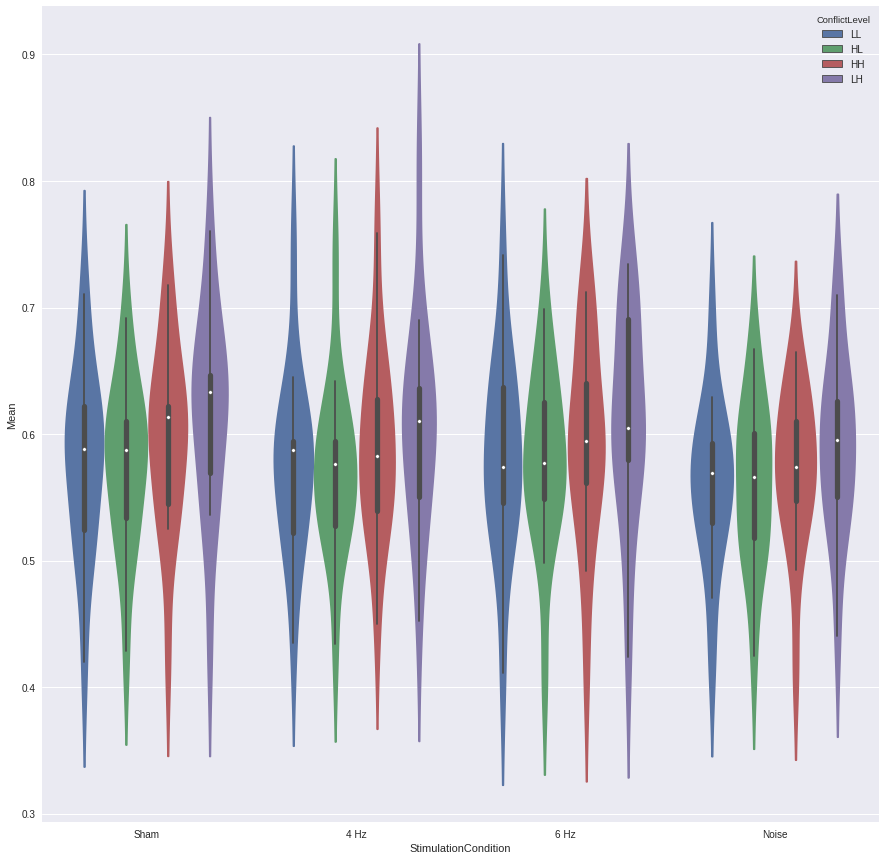

In [556]:
plt.figure(figsize=(15, 15))

plotted = sns.violinplot(y="Mean", x = "StimulationCondition", hue = 'ConflictLevel', data = DF_Conflict_statistics, 
            order=['Sham','4Hz','6Hz','Noise'], hue_order = ['LL','LH','HH','HL'],);

DF_Conflict_statistics[(DF_Conflict_statistics["StimulationCondition"] == 'Noise' )&(DF_Conflict_statistics["ConflictLevel"] == 'HH' )].Mean.mean()



0.5852050301254852

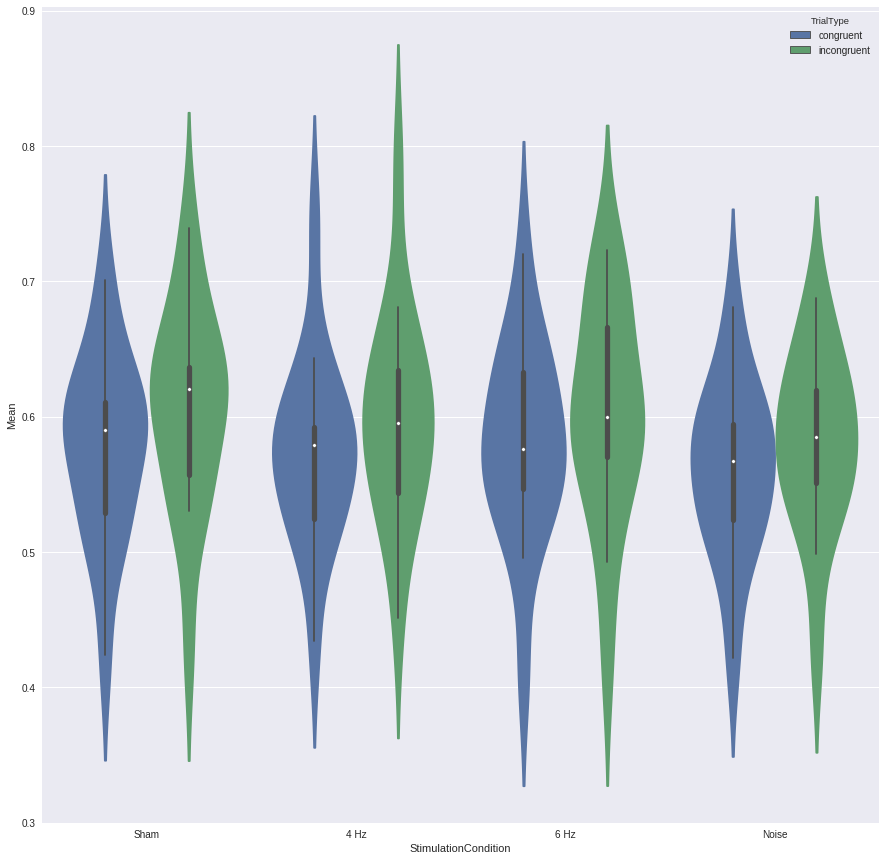

In [533]:

plt.figure(figsize=(15, 15))

plotted = sns.violinplot(y="Mean", x = "StimulationCondition", hue = 'TrialType', data = DF_RT_statistics, 
            order=['Sham','4Hz','6Hz','Noise'], hue_order = ['congruent','incongruent'],
           );

DF_RT_statistics[(DF_RT_statistics["StimulationCondition"] == 'Noise' )&(DF_RT_statistics["TrialType"] == 'incongruent' )].Mean.median()
#DF_RT_statistics[(DF_RT_statistics["StimulationCondition"] == 'Sham' )&(DF_RT_statistics["TrialType"] == 'incongruent' )]["Mean"].mean()

In [60]:
DataFrameComplete.rename(index = str, columns={'StimulationCondition':'Condition'})
toplot = DataFrameComplete.loc[(DataFrameComplete.Response == 1) & (DataFrameComplete.RT > 0.2)]
toplot
DataFrameComplete

TrialType lettercolor Response        RT  order StimulationCondition  \
0        congruent        Blue        1  0.917367    0.0                  4Hz   
1        congruent      Purple        1  1.045938    1.0                  4Hz   
2      incongruent       Green        1  0.812083    2.0                  4Hz   
3        congruent         Red        1  0.563087    3.0                  4Hz   
4        congruent        Blue        0  0.928785    4.0                  4Hz   
5      incongruent         Red        1  0.745480    5.0                  4Hz   
6      incongruent      Purple        1  0.662152    6.0                  4Hz   
7      incongruent         Red        1  0.828759    7.0                  4Hz   
8      incongruent        Blue        1  0.945956    8.0                  4Hz   
9      incongruent        Blue        1  0.745484    9.0                  4Hz   
10     incongruent        Blue        1  0.645555   10.0                  4Hz   
11     incongruent        Blue        1  0.617249   11.0                  4Hz   
12     incongruent        Blue        1  0.562185   12.0                  4Hz   
13     incongruent         Red        1  0.946076   13.0                  4Hz   
14       congruent       Green        1  0.595470   14.0                  4Hz   
15     incongruent       Green        1  0.578897   15.0                  4Hz   
16       congruent       Green        1  0.595657   16.0                  4Hz   
17     incongruent       Green        1  0.495638   17.0                  4Hz   
18     incongruent       Green        1  0.496311   18.0                  4Hz   
19       congruent       Green        1  0.478750   19.0                  4Hz   
20     incongruent      Purple        1  0.846610   20.0                  4Hz   
21       congruent        Blue        1  0.645356   21.0                  4Hz   
22       congruent       Green        1  0.645184   22.0                  4Hz   
23       congruent         Red        1  0.546520   23.0                  4Hz   
24     incongruent      Purple        1  0.683705   24.0                  4Hz   
25     incongruent         Red        1  0.712642   25.0                  4Hz   
26     incongruent         Red        1  0.584085   26.0                  4Hz   
27     incongruent         Red        1  0.662278   27.0                  4Hz   
28     incongruent      Purple        1  0.628994   28.0                  4Hz   
29     incongruent       Green        1  0.729833   29.0                  4Hz   
...            ...         ...      ...       ...    ...                  ...   
38882  incongruent       Green        1  0.550719  578.0                  6Hz   
38883  incongruent      Purple        1  0.584060  579.0                  6Hz   
38884  incongruent         Red        1  0.462128  580.0                  6Hz   
38885  incongruent        Blue        1  0.712659  581.0                  6Hz   
38886    congruent       Green        0  0.495462  582.0                  6Hz   
38887    congruent      Purple        1  0.579746  583.0                  6Hz   
38888  incongruent        Blue        1  0.567118  584.0                  6Hz   
38889  incongruent        Blue        1  0.395823  585.0                  6Hz   
38890  incongruent         Red        1  0.612753  586.0                  6Hz   
38891    congruent       Green        1  0.495512  587.0                  6Hz   
38892  incongruent       Green        1  0.380339  588.0                  6Hz   
38893  incongruent      Purple        1  0.433948  589.0                  6Hz   
38894  incongruent        Blue        1  0.495631  590.0                  6Hz   
38895    congruent        Blue        1  0.360363  591.0                  6Hz   
38896    congruent      Purple        1  0.479251  592.0                  6Hz   
38897  incongruent      Purple        1  0.378424  593.0                  6Hz   
38898    congruent      Purple        1  0.329271  594.0                  6Hz   
38899  incongruent      Purple        1 

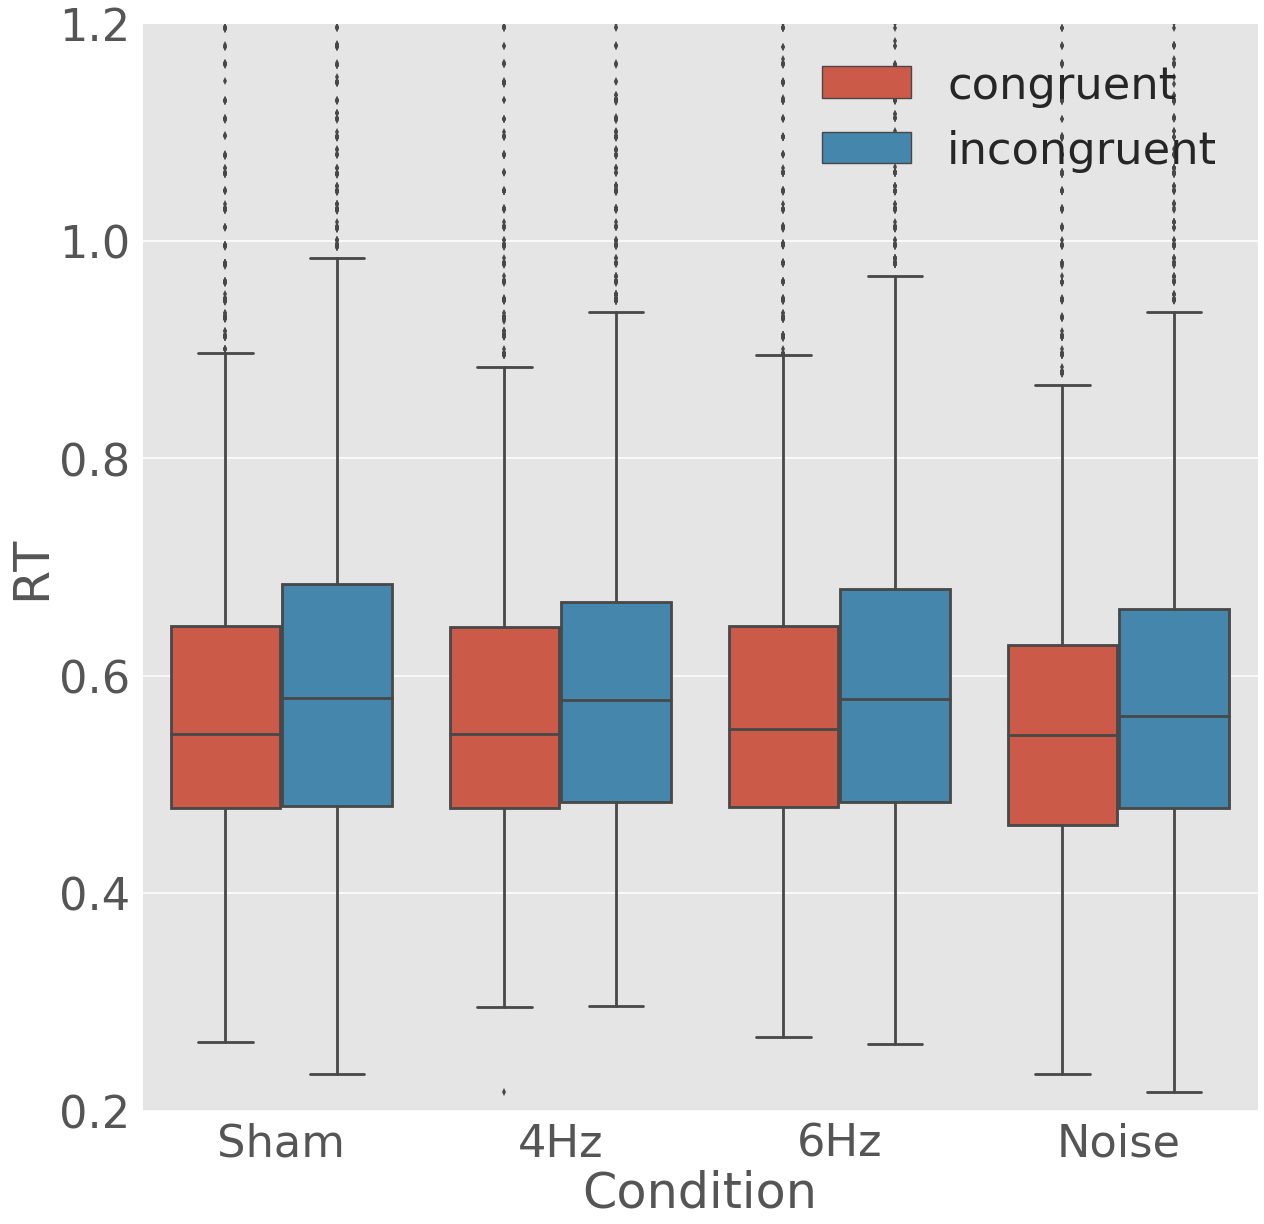

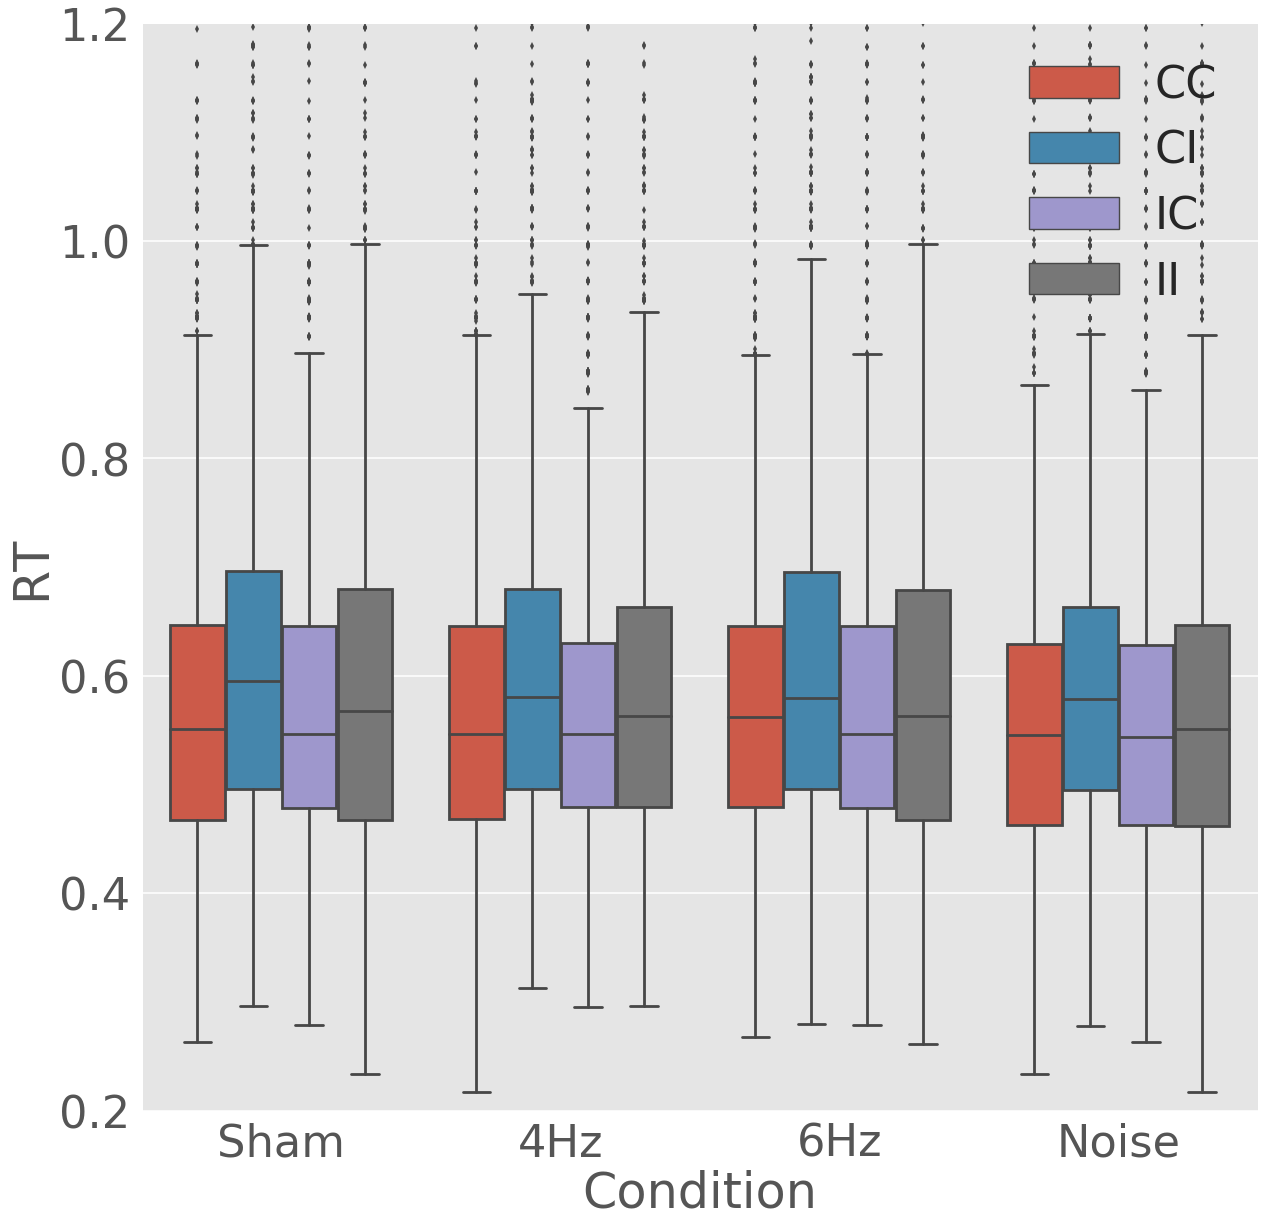

In [87]:
# proper plotting for poster:

DataFrameComplete = DataFrameComplete_Main.copy()
toplot = DataFrameComplete.loc[(DataFrameComplete.Response == 1) & (DataFrameComplete.RT > 0.2)] # &  (DataFrameComplete.RT <= 1)]
toplot = toplot.rename(index = str, columns={'StimulationCondition':'Condition'})
with sns.plotting_context("poster",font_scale=2.8):
  plt.figure(figsize=(20, 20))
  plotted = sns.boxplot(y="RT", x = "Condition", hue = 'TrialType', data = toplot, 
            order=['Sham','4Hz','6Hz','Noise'], hue_order = ['congruent','incongruent'],);
  sns.plt.ylim(0.2, 1.2)
  sns.plt.legend(loc = 1)
  #plt.setp(plotted.get_legend().get_texts(), fontsize='42') # for legend text
  #plt.setp(plotted.get_legend().get_title(), fontsize='52') # for legend title

DictRename = {'LL': 'CC', 'LH': 'CI', 'HH': 'II','HL': 'IC'} 
for key, value in DictRename.items():
    toplot.loc[toplot.ConflictLevel == key,'ConflictLevel'] = value      
    
with sns.plotting_context("poster",font_scale=2.8):
  plt.figure(figsize=(20, 20))    
  plotted = sns.boxplot(y="RT", x = "Condition", hue = 'ConflictLevel', data = toplot, 
            order=['Sham','4Hz','6Hz','Noise'], hue_order = ['CC','CI','IC','II'],);
  sns.plt.ylim(0.2, 1.2)
  sns.plt.legend(loc = 1)

In [86]:

toplot

TrialType lettercolor Response        RT  order Condition  \
0        congruent        Blue        1  0.917367    0.0       4Hz   
1        congruent      Purple        1  1.045938    1.0       4Hz   
2      incongruent       Green        1  0.812083    2.0       4Hz   
3        congruent         Red        1  0.563087    3.0       4Hz   
5      incongruent         Red        1  0.745480    5.0       4Hz   
6      incongruent      Purple        1  0.662152    6.0       4Hz   
7      incongruent         Red        1  0.828759    7.0       4Hz   
8      incongruent        Blue        1  0.945956    8.0       4Hz   
9      incongruent        Blue        1  0.745484    9.0       4Hz   
10     incongruent        Blue        1  0.645555   10.0       4Hz   
11     incongruent        Blue        1  0.617249   11.0       4Hz   
12     incongruent        Blue        1  0.562185   12.0       4Hz   
13     incongruent         Red        1  0.946076   13.0       4Hz   
14       congruent       Green        1  0.595470   14.0       4Hz   
15     incongruent       Green        1  0.578897   15.0       4Hz   
16       congruent       Green        1  0.595657   16.0       4Hz   
17     incongruent       Green        1  0.495638   17.0       4Hz   
18     incongruent       Green        1  0.496311   18.0       4Hz   
19       congruent       Green        1  0.478750   19.0       4Hz   
20     incongruent      Purple        1  0.846610   20.0       4Hz   
21       congruent        Blue        1  0.645356   21.0       4Hz   
22       congruent       Green        1  0.645184   22.0       4Hz   
23       congruent         Red        1  0.546520   23.0       4Hz   
24     incongruent      Purple        1  0.683705   24.0       4Hz   
25     incongruent         Red        1  0.712642   25.0       4Hz   
26     incongruent         Red        1  0.584085   26.0       4Hz   
27     incongruent         Red        1  0.662278   27.0       4Hz   
28     incongruent      Purple        1  0.628994   28.0       4Hz   
29     incongruent       Green        1  0.729833   29.0       4Hz   
30       congruent      Purple        1  0.745693   30.0       4Hz   
...            ...         ...      ...       ...    ...       ...   
38879    congruent         Red        1  0.414030  575.0       6Hz   
38880    congruent      Purple        1  0.479270  576.0       6Hz   
38882  incongruent       Green        1  0.550719  578.0       6Hz   
38883  incongruent      Purple        1  0.584060  579.0       6Hz   
38884  incongruent         Red        1  0.462128  580.0       6Hz   
38885  incongruent        Blue        1  0.712659  581.0       6Hz   
38887    congruent      Purple        1  0.579746  583.0       6Hz   
38888  incongruent        Blue        1  0.567118  584.0       6Hz   
38889  incongruent        Blue        1  0.395823  585.0       6Hz   
38890  incongruent         Red        1  0.612753  586.0       6Hz   
38891    congruent       Green        1  0.495512  587.0       6Hz   
38892  incongruent       Green        1  0.380339  588.0       6Hz   
38893  incongruent      Purple        1  0.433948  589.0       6Hz   
38894  incongruent        Blue        1  0.495631  590.0       6Hz   
38895    congruent        Blue        1  0.360363  591.0       6Hz   
38896    congruent      Purple        1  0.479251  592.0       6Hz   
38897  incongruent      Purple        1  0.378424  593.0       6Hz   
38898    congruent      Purple        1  0.329271  594.0       6Hz   
38899  incongruent      Purple        1  0.328310  595.0       6Hz   
38900  incongruent        Blue        1  0.712846  596.0       6Hz   
38901    congruent       Green        1  0.561877  597.0       6Hz   
38902    congruent        Blue        1  0.628245  598.0       6Hz   
38903    congruent      Purple        1  0.579118  599.0       6Hz   
38904    congruent       Green        1  0.529324  600.0       6Hz   
38905    congruent      Purple        1  0.495772  601.0       6Hz   
38906    congruent 

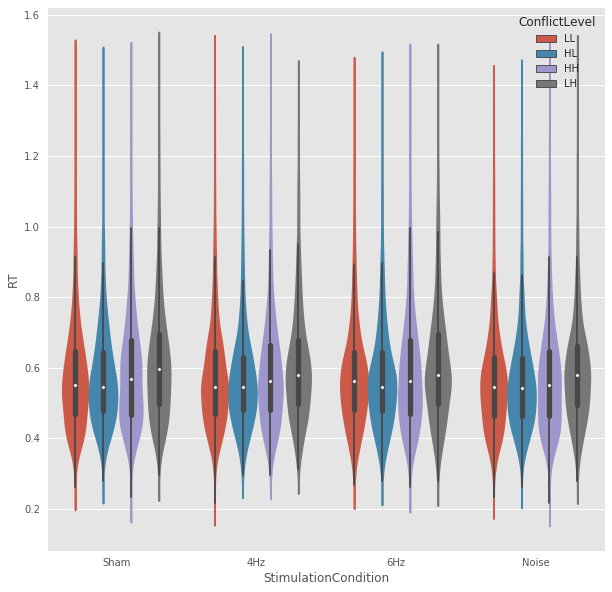

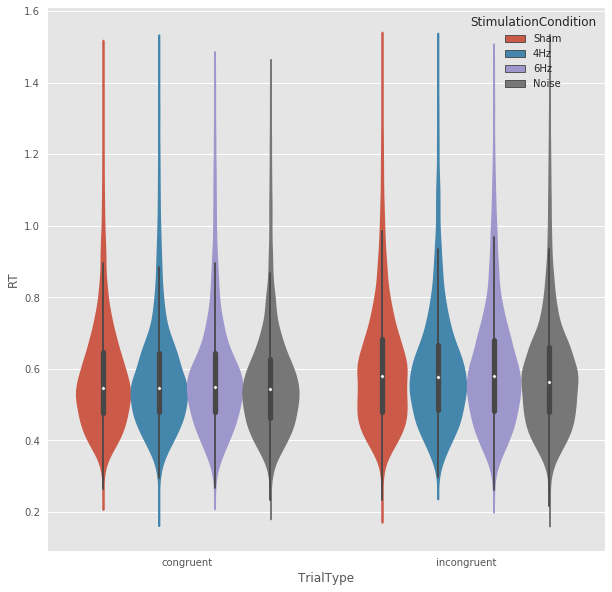

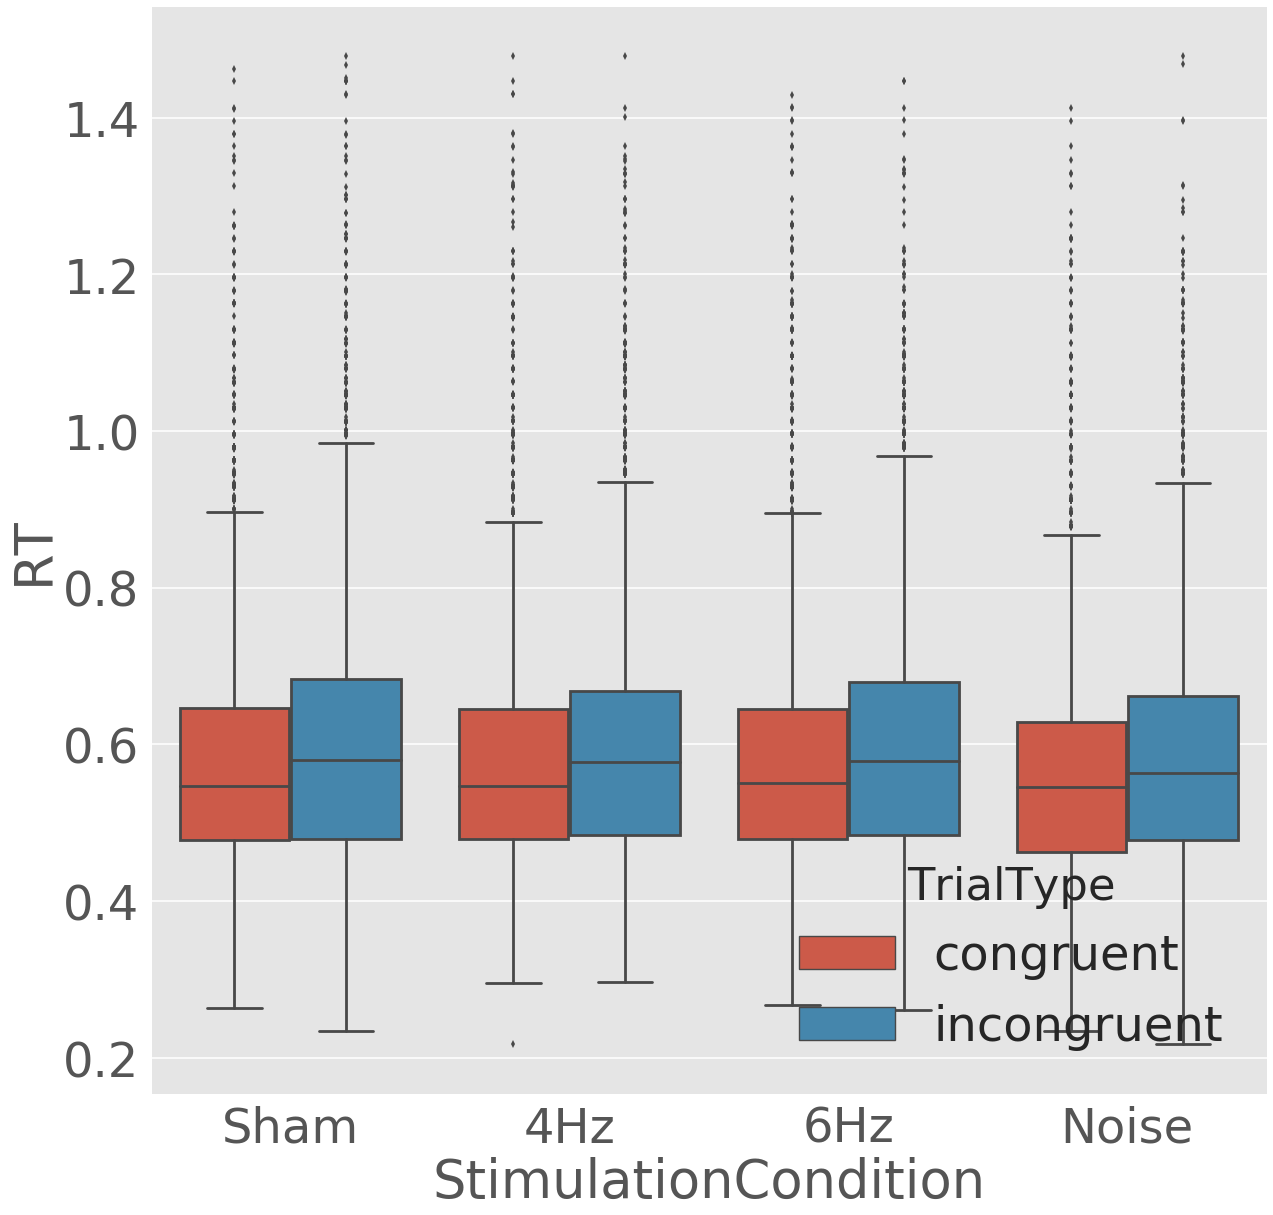

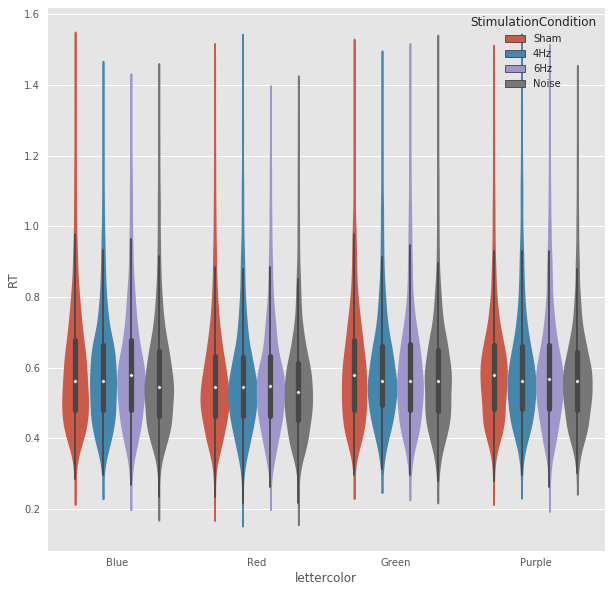

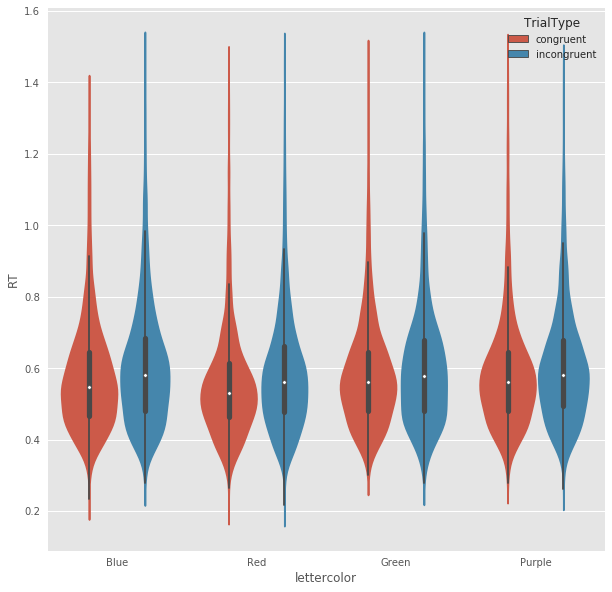

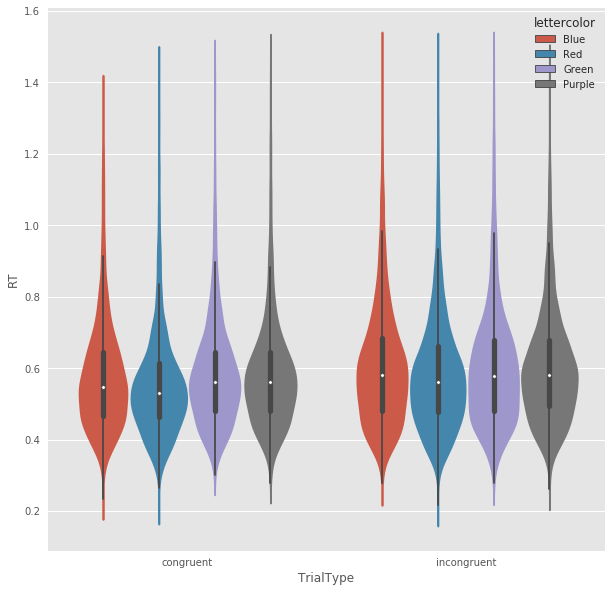

In [39]:
#DataFrameComplete.loc[((DataFrameComplete.session == '2A') | (DataFrameComplete.session == '1A')| (DataFrameComplete.session == 'A1')| (DataFrameComplete.session == 'A2')| (DataFrameComplete.session == 'A1-2')) , 'session'] = 'A'
#DataFrameComplete.loc[((DataFrameComplete.session == '1B') |  (DataFrameComplete.session == '2B')|  (DataFrameComplete.session == 'B1')|  (DataFrameComplete.session == 'B2')) , 'session'] = 'B'
DataFrameComplete = DataFrameComplete_Main.copy()
toplot = DataFrameComplete.loc[(DataFrameComplete.Response == 1) & (DataFrameComplete.RT > 0.2)] # &  (DataFrameComplete.RT <= 1)]

           );
  #plt.setp(plotted.get_legend().get_texts(), fontsize='42') # for legend text
  #plt.setp(plotted.get_legend().get_title(), fontsize='52') # for legend title
plt.figure(figsize=(10, 10))

plotted = sns.violinplot(y="RT", x = "StimulationCondition", hue = 'ConflictLevel', data = toplot, 
            order=['Sham','4Hz','6Hz','Noise'], hue_order = ['LL','HL','HH','LH'],
           );

plt.figure(figsize=(10, 10))

plotted = sns.violinplot(y="RT", x = "TrialType", hue = 'StimulationCondition', data = toplot, 
            order=['congruent','incongruent'], hue_order = ['Sham','4Hz','6Hz','Noise'],
           );

with sns.plotting_context("poster",font_scale=3):
  plt.figure(figsize=(20, 20))
  plotted = sns.boxplot(y="RT", x = "StimulationCondition", hue = 'TrialType', data = toplot, 
            order=['Sham','4Hz','6Hz','Noise'], hue_order = ['congruent','incongruent'],
           );
  #plt.setp(plotted.get_legend().get_texts(), fontsize='42') # for legend text
  #plt.setp(plotted.get_legend().get_title(), fontsize='52') # for legend title



plt.figure(figsize=(10, 10))

plotted = sns.violinplot(y="RT", x = "lettercolor", hue ='StimulationCondition', data = toplot, 
            order=['Blue','Red','Green','Purple'] ,hue_order = ['Sham','4Hz','6Hz','Noise'], 
           );

plt.figure(figsize=(10, 10))

plotted = sns.violinplot(y="RT", x = "lettercolor", hue ='TrialType', data = toplot, 
            order=['Blue','Red','Green','Purple'] ,hue_order = ['congruent','incongruent'], 
           );

plt.figure(figsize=(10, 10))

plotted = sns.violinplot(y="RT", x = "TrialType", hue ='lettercolor', data =toplot, 
            order=['congruent','incongruent'] ,hue_order = ['Blue','Red','Green','Purple'], 
           );


    


In [ ]:
# differentes between HL, LL, HH, LH

minuendHL = DataFrameComplete[(DataFrameComplete["TrialType"] == 'congruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'HL')]["RT"].mean()

subtrahendHL = DataFrameComplete[(DataFrameComplete["TrialType"] == 'congruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'HL') ]["RT"].mean()
difference = minuendHL - subtrahendHL
print('HL - difference between tacs - sham',difference)

minuendLH = DataFrameComplete[(DataFrameComplete["TrialType"] == 'incongruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'LH')]["RT"].mean()

subtrahendLH = DataFrameComplete[(DataFrameComplete["TrialType"] == 'incongruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'LH') ]["RT"].mean()
difference = minuendLH - subtrahendLH
print('LHverumSham',difference)

print('verum stimulation LH',minuendLH)

print('sham stimulation LH',subtrahendLH)

minuendHH = DataFrameComplete[(DataFrameComplete["TrialType"] == 'incongruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'HH')]["RT"].mean()

subtrahendHH = DataFrameComplete[(DataFrameComplete["TrialType"] == 'incongruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'HH')]["RT"].mean()
difference = minuendHH - subtrahendHH
print('HHverumSham',difference)

minuendLL = DataFrameComplete[(DataFrameComplete["TrialType"] == 'congruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'LL')]["RT"].mean()

subtrahendLL = DataFrameComplete[(DataFrameComplete["TrialType"] == 'congruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'LL')]["RT"].mean()
difference = minuendLL - subtrahendLL
print('LL - difference between tacs - sham',difference)

print('verum stimulation HH',minuendHH)

print('sham stimulation HH',subtrahendHH)

incongruentVerum = DataFrameComplete[(DataFrameComplete["TrialType"] == 'congruent')  
                                    ]["RT"].mean()



print ('incongruentVerum', incongruentVerum)

congruentVerum = DataFrameComplete[(DataFrameComplete["TrialType"] == 'congruent' )  
                  ]["RT"].mean()



print ('congruentVerum', congruentVerum)

print(minuendHH, minuendHL)
print ('Conflict detection cI - cC: tacs:', minuendLH - minuendLL )
print ('Conflict adaptation iI - iC: tacs:', minuendHH - minuendHL)
print ('LH - HH', minuendLH, minuendHH, minuendLH - minuendHH)
print ('HL - LL', minuendHL, minuendLL, minuendHL - minuendLL)
# congruency sequence effect: [cI - CC]-[iI iC]
print ('congruency sequence effect tacs' , (minuendLH - minuendLL) - (minuendHH - minuendHL))
print ('congruency sequence effect sham' , (subtrahendLH - subtrahendLL) - (subtrahendHH - subtrahendHL))


In [54]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import seaborn.apionly as sns
% matplotlib inline
import importlib
import seaborn
importlib.reload(seaborn);
DataFrameComplete

linecolor    TrialType  corrAns  NofTrial       ISI Response        RT  \
106      3 GRÜN    congruent      2.0       0.0  10.00000        2  0.834837   
107      3 GRÜN    congruent      2.0       1.0   0.60295        2  0.590948   
108       1 ROT  incongruent      3.0       2.0   0.65782        3  0.842361   
109      9 GELB    congruent      3.0       3.0   0.37575        3  0.691485   
110      4 GRÜN  incongruent      3.0       4.0   0.59359        3  0.823725   
111     11 GELB  incongruent      2.0       5.0   0.69992        2  0.714757   
112       1 ROT  incongruent      3.0       6.0   0.64979        3  0.710633   
113     11 GELB  incongruent      2.0       7.0   0.39149        2  0.775869   
114     11 GELB  incongruent      2.0       8.0   0.30145        2  0.676785   
115     10 GELB  incongruent      2.0       9.0   0.31533        2  0.835561   
116      6 BLAU    congruent      3.0      10.0   0.41019        3  0.630994   
117      5 GRÜN  incongruent      3.0      11.0   0.38112        3  0.554523   
118      8 BLAU  incongruent      2.0      12.0   0.58408        2  0.901276   
119      4 GRÜN  incongruent      3.0      13.0   0.39149        3  0.591791   
120       1 ROT  incongruent      3.0      14.0   0.31100        3  0.686470   
121       2 ROT  incongruent      3.0      15.0   0.55602        3  0.552079   
122      7 BLAU  incongruent      2.0      16.0   0.41606        2  1.083363   
123      9 GELB    congruent      3.0      17.0   0.39149        3  0.821117   
124       0 ROT    congruent      2.0      18.0   0.45577        2  0.672648   
125      9 GELB    congruent      3.0      19.0   0.31482        3  0.541137   
126      8 BLAU  incongruent      2.0      20.0   0.31533        2  1.147031   
127     11 GELB  incongruent      2.0      21.0   0.30145        2  0.605186   
128      3 GRÜN    congruent      2.0      22.0   0.55167        2  0.495385   
129       0 ROT    congruent      2.0      23.0   0.67007        2  0.673828   
130     11 GELB  incongruent      2.0      24.0   0.37249        2  0.543388   
131       1 ROT  incongruent      3.0      25.0   0.34332        3  0.661612   
132      4 GRÜN  incongruent      3.0      26.0   0.31482        3  0.555577   
133      9 GELB    congruent      3.0      27.0   0.60055        3  0.481238   
134     10 GELB  incongruent      2.0      28.0   0.55602        2  0.653388   
135      9 GELB    congruent      3.0      29.0   0.43134        3  0.787475   
...         ...          ...      ...       ...       ...      ...       ...   
11540     1 ROT  incongruent      3.0     570.0   0.37497        3  0.479254   
11541    6 BLAU    congruent      3.0     571.0   0.59359        3  0.441435   
11542    6 BLAU    congruent      3.0     572.0   0.38368        3  0.524763   
11543     0 ROT    congruent      2.0     573.0   0.59133        2  0.757693   
11544    9 GELB    congruent      3.0     574.0   0.42924        3  0.513594   
11545    9 GELB    congruent      3.0     575.0   0.64979        3  0.369187   
11546   11 GELB  incongruent      2.0     576.0   0.48307        2  0.489167   
11547    6 BLAU    congruent      3.0     577.0   0.46005        3  0.524773   
11548   11 GELB  incongruent      2.0     578.0   0.52129        2  0.490436   
11549     1 ROT  incongruent      3.0     579.0   0.31482        3  0.430383   
11550   10 GELB  incongruent      2.0     580.0   0.51807        2  0.490844   
11551    5 GRÜN  incongruent      3.0     581.0   0.58569        3  0.564845   
11552    5 GRÜN  incongruent      3.0     582.0   0.31613        3  0.479518   
11553    6 BLAU    congruent      3.0     583.0   0.43171        3  0.657828   
11554    7 BLAU  incongruent      2.0     584.0   0.58187        2  0.415039   
11555    9 GELB    congruent      3.0     585.0   0.40637        3  0.466570   
11556    6 BLAU    congruent      3.0     586.0   0.36382        3  0.464854   
11557     0 ROT    congruent      2.0     587.0   0.31100        2  0.382242   
11558 

In [45]:
# just for range estimation

# this line has to be uncommented - is not usefull anymore
#DataFrameComplete.loc[DataFrameComplete.Experiment == 'Stroop','session'] = 'A'

## drop the last line of the pandas dataframe
##DataFrameComplete.drop(DataFrameComplete.tail(1).index,inplace=True)

DataFrameComplete

linecolor    TrialType  corrAns  NofTrial       ISI Response        RT  \
106       GREEN    congruent      2.0       0.0  10.00000        1  0.834837   
107       GREEN    congruent      2.0       1.0   0.60295        1  0.590948   
108        BLUE  incongruent      3.0       2.0   0.65782        1  0.842361   
109      YELLOW    congruent      3.0       3.0   0.37575        1  0.691485   
110        BLUE  incongruent      3.0       4.0   0.59359        1  0.823725   
111       GREEN  incongruent      2.0       5.0   0.69992        1  0.714757   
112        BLUE  incongruent      3.0       6.0   0.64979        1  0.710633   
113       GREEN  incongruent      2.0       7.0   0.39149        1  0.775869   
114       GREEN  incongruent      2.0       8.0   0.30145        1  0.676785   
115         RED  incongruent      2.0       9.0   0.31533        1  0.835561   
116        BLUE    congruent      3.0      10.0   0.41019        1  0.630994   
117      YELLOW  incongruent      3.0      11.0   0.38112        1  0.554523   
118       GREEN  incongruent      2.0      12.0   0.58408        1  0.901276   
119        BLUE  incongruent      3.0      13.0   0.39149        1  0.591791   
120        BLUE  incongruent      3.0      14.0   0.31100        1  0.686470   
121      YELLOW  incongruent      3.0      15.0   0.55602        1  0.552079   
122         RED  incongruent      2.0      16.0   0.41606        1  1.083363   
123      YELLOW    congruent      3.0      17.0   0.39149        1  0.821117   
124         RED    congruent      2.0      18.0   0.45577        1  0.672648   
125      YELLOW    congruent      3.0      19.0   0.31482        1  0.541137   
126       GREEN  incongruent      2.0      20.0   0.31533        1  1.147031   
127       GREEN  incongruent      2.0      21.0   0.30145        1  0.605186   
128       GREEN    congruent      2.0      22.0   0.55167        1  0.495385   
129         RED    congruent      2.0      23.0   0.67007        1  0.673828   
130       GREEN  incongruent      2.0      24.0   0.37249        1  0.543388   
131        BLUE  incongruent      3.0      25.0   0.34332        1  0.661612   
132        BLUE  incongruent      3.0      26.0   0.31482        1  0.555577   
133      YELLOW    congruent      3.0      27.0   0.60055        1  0.481238   
134         RED  incongruent      2.0      28.0   0.55602        1  0.653388   
135      YELLOW    congruent      3.0      29.0   0.43134        1  0.787475   
...         ...          ...      ...       ...       ...      ...       ...   
11540      BLUE  incongruent      3.0     570.0   0.37497        1  0.479254   
11541      BLUE    congruent      3.0     571.0   0.59359        1  0.441435   
11542      BLUE    congruent      3.0     572.0   0.38368        1  0.524763   
11543       RED    congruent      2.0     573.0   0.59133        1  0.757693   
11544    YELLOW    congruent      3.0     574.0   0.42924        1  0.513594   
11545    YELLOW    congruent      3.0     575.0   0.64979        1  0.369187   
11546     GREEN  incongruent      2.0     576.0   0.48307        1  0.489167   
11547      BLUE    congruent      3.0     577.0   0.46005        1  0.524773   
11548     GREEN  incongruent      2.0     578.0   0.52129        1  0.490436   
11549      BLUE  incongruent      3.0     579.0   0.31482        1  0.430383   
11550       RED  incongruent      2.0     580.0   0.51807        1  0.490844   
11551    YELLOW  incongruent      3.0     581.0   0.58569        1  0.564845   
11552    YELLOW  incongruent      3.0     582.0   0.31613        1  0.479518   
11553      BLUE    congruent      3.0     583.0   0.43171        1  0.657828   
11554       RED  incongruent      2.0     584.0   0.58187        1  0.415039   
11555    YELLOW    congruent      3.0     585.0   0.40637        1  0.466570   
11556      BLUE    congruent      3.0     586.0   0.36382        1  0.464854   
11557       RED    congruent      2.0     587.0   0.31100        1  0.382242   
11558 

In [13]:
# Conditional Accuracy 
def CAFsingle (DataFrame,lowerboundary,upperboundary,participant,condition,congruency):
   
  correcttrials =  len(DataFrame.loc[(DataFrame['session'].str.contains(condition)) &(DataFrame.TrialType == congruency) &(DataFrame.participant == participant) & (DataFrame.Response == 1)  & (DataFrame.RT >= lowerboundary) & (DataFrame.RT < upperboundary)])
  trials = len(DataFrame.loc[(DataFrame['session'].str.contains(condition)) &(DataFrame.TrialType == congruency) & (DataFrame.participant == participant) & (DataFrame.RT >= lowerboundary)& (DataFrame.RT < upperboundary)])
  try: 
    value = correcttrials / trials
  except: 
    value = float('NaN') 
   
  if trials < 3:
    value = float('NaN')    
  return value

def CAF (DataFrame,participant,condition,congruency): 
  list = []
#  for i in [0.2+0.1*g for g in range(0,13)]:
  for i in [0.2+0.2*g for g in range(0,5)]:
#    value = CAFsingle(DataFrame,i,i+0.1,participant,condition,congruency)
    value = CAFsingle(DataFrame,i,i+0.2,participant,condition,congruency)
    
    list.append(value)
  #accurcacy = len(DataFrame.loc[(DataFrame['session'].str.contains(condition)) &(DataFrame.participant == participant) & (DataFrame.Response == 1)]) / len(DataFrame.loc[(DataFrame['session'].str.contains(condition)) &(DataFrame.participant == participant)])
  return list #, accurcacy

#Times = [0.25+i*0.1 for i in range(0,13)]
Times = [20 + i*20 for i in range(0,5)]

def OverallCAF (DataFrame,condition,congruency):
  participantlist = DataFrame.participant.unique()

#  series = {participantlist[0] : pd.Series(CAF(DataFrame,participantlist[0],condition,congruency), index=['0.25','0.35', '0.45', '0.55','0.65', '0.75', '0.85','0.95', '1.05', '1.15','1.25', '1.35', '1.45'])}  
  series = {participantlist[0] : pd.Series(CAF(DataFrame,participantlist[0],condition,congruency), index=['20','40','60','80','100'])}  
  DF = pd.DataFrame(series)
  for y in participantlist[1:]:        
    series = {y : pd.Series(CAF(DataFrame,y,condition,congruency), index=['20','40','60','80','100'])}  
    series = pd.DataFrame(series)
    DF = pd.concat([DF,series], axis =1)
  DF['mean'] = DF.mean(axis=1, skipna = True)
   
  return DF

def getAccuracies(DataFrame,condition, congruency):
  trials=  len(DataFrame.loc[(DataFrame['session'].str.contains(condition))  &(DataFrame.TrialType == congruency) ])          
  correcttrials = len(DataFrame.loc[(DataFrame['session'].str.contains(condition)) &(DataFrame.TrialType == congruency) & (DataFrame.Response == 1)]) 
  return correcttrials / trials




df_A_con   = OverallCAF(DataFrameComplete.loc[DataFrameComplete.RT <= 1],'A','congruent')
df_A_incon = OverallCAF(DataFrameComplete.loc[DataFrameComplete.RT <= 1],'A','incongruent')
df_B_con   = OverallCAF(DataFrameComplete.loc[DataFrameComplete.RT <= 1],'B','congruent')
df_B_incon = OverallCAF(DataFrameComplete.loc[DataFrameComplete.RT <= 1],'B','incongruent')

AccuracyAcon = getAccuracies(DataFrameComplete.loc[DataFrameComplete.RT <= 1],'A','congruent')
AccuracyAincon = getAccuracies(DataFrameComplete.loc[DataFrameComplete.RT <= 1],'A','incongruent')

AccuracyBcon = getAccuracies(DataFrameComplete.loc[DataFrameComplete.RT <= 1],'B','congruent')
AccuracyBincon = getAccuracies(DataFrameComplete.loc[DataFrameComplete.RT <= 1],'B','incongruent')


sns.pointplot(Times,df_A_con['mean'], color = 'blue')
sns.pointplot(Times,df_A_incon['mean'],color = 'green')
sns.pointplot(Times,df_B_con['mean'],color = 'red')
lm = sns.pointplot(Times,df_B_incon['mean'],color = 'yellow')
axes = lm.axes
axes.set_ylim(0.7,)

print(AccuracyAcon,AccuracyAincon, AccuracyBcon, AccuracyBincon)

ZeroDivisionError: division by zero

0.9699608184588594 0.9635627530364372 0.9597345132743362 0.9655330882352942


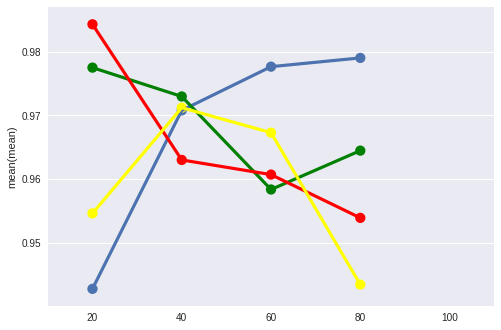

In [19]:
sns.pointplot(Times,df_A_con['mean'])
sns.pointplot(Times,df_A_incon['mean'],color = 'green')
sns.pointplot(Times,df_B_con['mean'],color = 'red')
sns.pointplot(Times,df_B_incon['mean'],color = 'yellow')



print(AccuracyAcon,AccuracyAincon, AccuracyBcon, AccuracyBincon)

In [ ]:
def distributions(DataFrame, Proband, condition):
  allcongruent_correct = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['RT']
  allincongruent_correct = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['RT']
  return  allcongruent_correct,allincongruent_correct
def getRTsGeneral(DataFrame, condition):
  RTs = DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.Response == 1.0)]['RT']    
  return RTs
def getRTs(DataFrame, condition, congruency):
  RTs = DataFrame[(DataFrame['session'].str.contains(condition))& (DataFrame.TrialType == congruency) & (DataFrame.Response == 1.0)]['RT']    
  return RTs
def getRTsparticipant(DataFrame, Proband,condition, congruency):
  RTs = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == Proband)& (DataFrame.TrialType == congruency) & (DataFrame.Response == 1.0)]['RT']    
  return RTs
def getRTsGeneral(DataFrame, condition):
  RTs = DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.Response == 1.0)]['RT']    
  return RTs

# Probandendaten zur DMC einspeisen
def DMCQuantiles (DataFrame, Proband,condition):
#Zielstruktur:
#data structure: 
#data[0]:     number of correct trials
#data[1]:     proportion correct
#data[2:7]:   .1, .3, .5, .7, .9 RT quantiles for correct trials (in ms)
#data[7]:     number of incorrect trials
#data[8]:     proportion of incorrect trials
#data[9:14]:  RT quantiles for incorrect trials (in ms). Because we have a number of errors > 10 in each congruency condition, .1, .3, .5 , .7, .9 RT quantiles are computed

  congruent_data = []
  congruent_data_lang = []

  NrCorrTrials = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['participant'].count()
  RatioCorr = NrCorrTrials / DataFrame[(DataFrame['session'].str.contains(condition))& (DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent')]['participant'].count()
  AllCongCorr = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['RT']

  NrInCorrTrials = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrameComplete.Response == 0.0)]['participant'].count()
  RatioInCorr = NrInCorrTrials / DataFrame[(DataFrame['session'].str.contains(condition))& (DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent')]['participant'].count()
  AllCongInCorr = DataFrame[ (DataFrame['session'].str.contains(condition)) &(DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 0.0)]['RT']



  congruent_data.append(NrCorrTrials)
  congruent_data.append(RatioCorr)
  for i in range(1,11,2):
    congruent_data.append(AllCongCorr.quantile(q = i / 10)*1000)  

 
  congruent_data.append(NrInCorrTrials)
  congruent_data.append(RatioInCorr)
  for i in range(1,11,2):
    congruent_data.append(AllCongInCorr.quantile(q = i / 10)*1000)  


    
  congruent_data_lang.append(NrCorrTrials)
  congruent_data_lang.append(RatioCorr)
  for i in range(1,11,1):
    congruent_data_lang.append(AllCongCorr.quantile(q = i / 10)*1000)  
    
  congruent_data_lang.append(NrInCorrTrials)
  congruent_data_lang.append(RatioInCorr)
  for i in range(1,11,1):
    congruent_data_lang.append(AllCongInCorr.quantile(q = i / 10)*1000)  


 # print( RatioCorr + RatioInCorr == 1)

  incongruent_data = []
  incongruent_data_lang = []
    
  NrCorrTrials = DataFrame[(DataFrame['session'].str.contains(condition))& (DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['participant'].count()
  RatioCorr = NrCorrTrials / DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent')]['participant'].count()
  AllIncongCorr = DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['RT']

  NrInCorrTrials = DataFrame[ (DataFrame['session'].str.contains(condition)) & (DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 0.0)]['participant'].count()
  RatioInCorr = NrInCorrTrials / DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent')]['participant'].count()
  AllIncongIncorr = DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 0.0)]['RT']

  incongruent_data.append(NrCorrTrials)
  incongruent_data.append(RatioCorr)
  for i in range(1,11,2):
    incongruent_data.append(AllIncongCorr.quantile(q = i / 10)*1000)


  incongruent_data.append(NrInCorrTrials)
  incongruent_data.append(RatioInCorr)
    
  for i in range(1,11,2):
    incongruent_data.append(AllIncongIncorr.quantile(q = i / 10)*1000)    
    

 
  incongruent_data_lang.append(NrCorrTrials)
  incongruent_data_lang.append(RatioCorr)
  for i in range(1,11,1):
    incongruent_data_lang.append(AllIncongCorr.quantile(q = i / 10)*1000)     
  incongruent_data_lang.append(NrInCorrTrials)
  incongruent_data_lang.append(RatioInCorr)
  for i in range(1,11,1):
    incongruent_data_lang.append(AllIncongIncorr.quantile(q = i / 10)*1000)     


 # print(RatioCorr + RatioInCorr == 1)
  return congruent_data,  incongruent_data


def DMCQuantilesCompleteData (DataFrame ,condition):
#Zielstruktur:
#data structure: 
#data[0]:     number of correct trials
#data[1]:     proportion correct
#data[2:7]:   .1, .3, .5, .7, .9 RT quantiles for correct trials (in ms)
#data[7]:     number of incorrect trials
#data[8]:     proportion of incorrect trials
#data[9:14]:  RT quantiles for incorrect trials (in ms). Because we have a number of errors > 10 in each congruency condition, .1, .3, .5 , .7, .9 RT quantiles are computed

  congruent_data = []
  congruent_data_lang = []

  NrCorrTrials = DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['participant'].count()
  RatioCorr = NrCorrTrials / DataFrame[(DataFrame['session'].str.contains(condition))& (DataFrame.TrialType == 'congruent')]['participant'].count()
  AllCongCorr = DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['RT']

  NrInCorrTrials = DataFrame[(DataFrame['session'].str.contains(condition))&  (DataFrame.TrialType == 'congruent') & (DataFrameComplete.Response == 0.0)]['participant'].count()
  RatioInCorr = NrInCorrTrials / DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.TrialType == 'congruent')]['participant'].count()
  AllCongInCorr = DataFrame[ (DataFrame['session'].str.contains(condition))  & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 0.0)]['RT']



  congruent_data.append(NrCorrTrials)
  congruent_data.append(RatioCorr)
  for i in range(1,11,2):
    congruent_data.append(AllCongCorr.quantile(q = i / 10)*1000)  

 
  congruent_data.append(NrInCorrTrials)
  congruent_data.append(RatioInCorr)
  for i in range(1,11,2):
    congruent_data.append(AllCongInCorr.quantile(q = i / 10)*1000)  


    
  congruent_data_lang.append(NrCorrTrials)
  congruent_data_lang.append(RatioCorr)
  for i in range(1,11,1):
    congruent_data_lang.append(AllCongCorr.quantile(q = i / 10)*1000)  
    
  congruent_data_lang.append(NrInCorrTrials)
  congruent_data_lang.append(RatioInCorr)
  for i in range(1,11,1):
    congruent_data_lang.append(AllCongInCorr.quantile(q = i / 10)*1000)  


 # print( RatioCorr + RatioInCorr == 1)

  incongruent_data = []
  incongruent_data_lang = []
    
  NrCorrTrials = DataFrame[(DataFrame['session'].str.contains(condition))& (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['participant'].count()
  RatioCorr = NrCorrTrials / DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.TrialType == 'incongruent')]['participant'].count()
  AllIncongCorr = DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['RT']

  NrInCorrTrials = DataFrame[ (DataFrame['session'].str.contains(condition))& (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 0.0)]['participant'].count()
  RatioInCorr = NrInCorrTrials / DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.TrialType == 'incongruent')]['participant'].count()
  AllIncongIncorr = DataFrame[(DataFrame['session'].str.contains(condition))  & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 0.0)]['RT']

  incongruent_data.append(NrCorrTrials)
  incongruent_data.append(RatioCorr)
  for i in range(1,11,2):
    incongruent_data.append(AllIncongCorr.quantile(q = i / 10)*1000)


  incongruent_data.append(NrInCorrTrials)
  incongruent_data.append(RatioInCorr)
    
  for i in range(1,11,2):
    incongruent_data.append(AllIncongIncorr.quantile(q = i / 10)*1000)    
    

 
  incongruent_data_lang.append(NrCorrTrials)
  incongruent_data_lang.append(RatioCorr)
  for i in range(1,11,1):
    incongruent_data_lang.append(AllIncongCorr.quantile(q = i / 10)*1000)     
  incongruent_data_lang.append(NrInCorrTrials)
  incongruent_data_lang.append(RatioInCorr)
  for i in range(1,11,1):
    incongruent_data_lang.append(AllIncongIncorr.quantile(q = i / 10)*1000)     


 # print(RatioCorr + RatioInCorr == 1)
  return congruent_data,  incongruent_data


In [14]:
for i in DataFrameComplete.participant.unique():
    print (i)
condition = 'verum'
DMCQuantiles(DataFrameComplete, 'sdlpfc10', condition)
DataFrame = DataFrameComplete
NrCorrTrials = DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['participant']
DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.TrialType == 'congruent') ]

sdlpfc10
sdlpfc11
sdlpfc1
sdlpfc2
sdlpfc3
sdlpfc4
sdlpfc5
sdlpfc6
sdlpfc8
sdlpfc9


NameError: name 'DMCQuantiles' is not defined

In [30]:
# exporting files
abc = 1
StimCondList = ['verum','sham']

try:
  os.chdir(folder)    
  for ID in DataFrameComplete.participant.unique():
    for StimCond in StimCondList:

      congruent_data, incongruent_data = DMCQuantiles(DataFrameComplete, ID, StimCond)
    
      f = open("MyConfig"+str(abc)+".py",'w')
      f.write("ID = '" + ID + StimCond)
      f.write("'\n")
      f.write("save_path = '/scratch/lehr2/DMC/" + ID +StimCond + "/'\n") 
      f.write("congruent_data = "+str(congruent_data))
      f.write("\n")
      f.write("incongruent_data ="+str(incongruent_data))
      f.write("\n")
      f.close()

      abc = abc + 1
    
  ID = 'all'   
  for StimCond in StimCondList:    
    congruent_data, incongruent_data = DMCQuantilesCompleteData(DataFrameComplete.loc[DataFrameComplete.participant != 'sdlpfc11'], StimCond)

    f = open("MyConfig"+str(abc)+".py",'w')
    f.write("ID = '" + StudyName + StimCond)
    f.write("'\n")
    f.write("save_path = '/scratch/lehr2/DMC/" + ID +StimCond + "/'\n") 
    f.write("congruent_data = "+str(congruent_data))
    f.write("\n")
    f.write("incongruent_data ="+str(incongruent_data))
    f.write("\n")
    f.close()

    abc = abc + 1
except:
    print('couldnt work in the changed working directory')

/home/albert/anaconda3/envs/datasci/lib/python3.6/site-packages/ipykernel_launcher.py:124: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [34]:
def getRTmeanSTD (DataFrame,condition):
  RT_congruent = getRTs(DataFrame,condition,'congruent')
  print('RT_congruent',RT_congruent.mean()*1000)
  print(RT_congruent.std()*1000)
  RT_incongruent = getRTs(DataFrame,condition,'incongruent')
  print('RT_incongruent',RT_incongruent.mean()*1000)
  print(RT_incongruent.std()*1000)
  print('StroopEffect', (RT_incongruent.mean() - RT_congruent.mean())*1000) 
#  return RT_congruent, RT_incongruent



# get the SEM => actually think about taking the mean for one participant and then for all
print('meanRT',DataFrameComplete.loc[(DataFrameComplete.participant == 'janine') &(DataFrameComplete.Response == 1.0)].RT.mean()*1000)
print('STD',DataFrameComplete.loc[(DataFrameComplete.participant == 'janine') & (DataFrameComplete.Response == 1.0)].RT.std()*1000)
getRTmeanSTD(DataFrameComplete.loc[DataFrameComplete.participant == 'Markus'],'A')
print('divider')
#getRTmeanSTD(DataFrameComplete.loc[DataFrameComplete.RT <= 1],'B')
print(DataFrameComplete.participant.unique())
print(len(DataFrameComplete.loc[ (DataFrameComplete.participant == 'janine') & (DataFrameComplete.Response == 0)]) / 600)
print(len(DataFrameComplete.loc[(DataFrameComplete.participant == 'janine') & (DataFrameComplete.Response == 0) & (DataFrameComplete.TrialType == 'congruent')] ) / 300)
print(len(DataFrameComplete.loc[(DataFrameComplete.participant == 'janine') & (DataFrameComplete.Response == 0) & (DataFrameComplete.TrialType == 'incongruent')] ) / 300)

#all:
print(len(DataFrameComplete.loc[  (DataFrameComplete.Response == 0)]) / len(DataFrameComplete))
print(len(DataFrameComplete.loc[ (DataFrameComplete.TrialType == 'congruent') & (DataFrameComplete.Response == 0)]) / len(DataFrameComplete.loc[DataFrameComplete.TrialType == 'incongruent']))
print(len(DataFrameComplete.loc[ (DataFrameComplete.TrialType == 'incongruent') & (DataFrameComplete.Response == 0)]) / len(DataFrameComplete.loc[DataFrameComplete.TrialType == 'incongruent']))


meanRT nan
STD nan


NameError: name 'getRTs' is not defined

In [28]:
# ['janine' 'Lennart' 'Lorenz' 'Mara' 'Markus']
congruent_data, congruent_data_lang, incongruent_data, incongruent_data_lang = DMCQuantilesCompleteData(DataFrameComplete, 'A')
print(congruent_data)
print(incongruent_data)

[1427, 0.96353814989871711, 424.8621762728, 485.4164239952, 549.589909846, 616.2667312658, 794.629382901, 54, 0.036461850101282917, 362.0403686077, 447.8645148451, 525.3333009309999, 678.6164327288, 926.2787076415002]
[1409, 0.95010114632501685, 430.39117185439994, 508.01965896979993, 571.383588482, 656.6603222397999, 865.5232015532, 74, 0.049898853674983146, 402.3221731184, 447.94110122589996, 517.0116047375, 633.6063994794, 964.7491436917002]


In [ ]:
###### Cumulative Distribution functions

def alldistributions(DataFrame,condition):
  participantlist = DataFrame.participant.unique()

  congruent_RTs_correct, incongruent_RTs_correct = distributions(DataFrame,participantlist[0],condition)

  con = {participantlist[0] :  pd.Series(congruent_RTs_correct.tolist())}
  incon = {participantlist[0] :  pd.Series(incongruent_RTs_correct.tolist())}
  CON = pd.DataFrame(con)
  INCON = pd.DataFrame(incon)
    
#  for y in participantlist[1:]:        
#    congruent_RTs_correct, incongruent_RTs_correct = distributions(DataFrame,y,condition)
#    
#    con = {y :  pd.Series(congruent_RTs_correct.tolist())}
#    con = pd.DataFrame(con)
#    CON = CON.append(con)
    
#    incon = {y :  pd.Series(incongruent_RTs_correct.tolist())}
#    incon = pd.DataFrame(incon)
#    INCON = INCON.append(incon)
     
    
  return CON, INCON 

toplot = DataFrameComplete.loc[DataFrameComplete.RT <= 1.5]

ACON, AINCON = alldistributions(toplot,'A')
BCON, BINCON = alldistributions(toplot,'B')

sns.distplot(ACON,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True),
            color='red')
sns.distplot(AINCON,
             hist_kws=dict(cumulative=True),
             kde_kws=dict(cumulative=True),
            color='yellow')


#sns.distplot(BCON,
#             hist_kws=dict(cumulative=True),
#             kde_kws=dict(cumulative=True),
#            color='violet')
#sns.distplot(BINCON,
#             hist_kws=dict(cumulative=True),
#             kde_kws=dict(cumulative=True),
#            color='yellow')




In [17]:
# Delta Plot

#    quantile differences ( ordinate) vs 
#    quantile  averages (abcissa) 


def DeltaPlot(DataFrame,condition):
  participantlist = DataFrame.participant.unique()    
  congruent, congruent_lang, incongruent, incongruent_lang= DMCQuantiles(DataFrameComplete,'SMRI1',condition)
  con = {participantlist[0] : pd.Series(congruent_lang[2:12], index=['0.1','0.2', '0.3', '0.4','0.5', '0.6', '0.7','0.8', '0.9','1'])}
  incon = {participantlist[0] : pd.Series(incongruent_lang[2:12], index=['0.1','0.2', '0.3', '0.4','0.5', '0.6', '0.7','0.8', '0.9','1'])}
  CON = pd.DataFrame(con)
  INCON = pd.DataFrame(incon)
    
  for y in participantlist[1:]:        
    congruent, congruent_lang, incongruent, incongruent_lang= DMCQuantiles(DataFrameComplete,y,condition)
    con = {y : pd.Series(congruent_lang[2:12], index=['0.1','0.2', '0.3', '0.4','0.5', '0.6', '0.7','0.8', '0.9','1'])}
    con = pd.DataFrame(con)
    CON = pd.concat([CON,con], axis =1)
    incon = {y : pd.Series(incongruent_lang[2:12], index=['0.1','0.2', '0.3', '0.4','0.5', '0.6', '0.7','0.8', '0.9','1'])}
    incon = pd.DataFrame(incon)
    INCON = pd.concat([INCON,incon], axis =1)  

  CON['mean'] = CON.mean(axis=1, skipna = True)
  INCON['mean'] = INCON.mean(axis=1, skipna = True)
  CON['std'] = CON.std(axis=1, skipna = True)
  INCON['std'] = INCON.std(axis=1, skipna = True)
    
  return CON, INCON


quantiles = [0.1 + i * 0.1 for i in range(0,10)]

def plotting(DataFrame,condition,colored,whattocalculate):
  CON, INCON = DeltaPlot(DataFrame,condition)
  x = []
  y = []    
  error = [] 
    #!!!!!!!!!!!!!change here to change the number of quantiles included
  for i in range(0,9):
    x[len(x):] = [((CON[whattocalculate][i] + INCON[whattocalculate][i]) / 2 )]
    y[len(y):] = [((+INCON[whattocalculate][i] - CON[whattocalculate][i]) )]
    # this error bar is potentially wrong, very potentially!
    error[len(error):] = [((+INCON['std'][i] + CON['std'][i]) / 2)]
  y = [i * 1000 for i in y]
  error = [i * 1000 for i in error]
  return x,y,error
  plt.show()    
#  lm = sns.pointplot(x,y,color = colored)
#  axes = lm.axes
#  axes.set_xlim(0.0,)


toplot = DataFrameComplete.loc[(DataFrameComplete.RT <= 1.5)]
#!!!!!!!!!!!!!!!!!!!!!!!!!!! change whattocalculate either to 'mean' or to 'SMRI1'.... in order to get the data
whattocalculate = 'mean'
xA,yA, errorA = plotting(toplot,'A','blue',whattocalculate)
xB,yB, errorB = plotting(toplot,'B','green',whattocalculate)

# calculate the SEM:
myInt = math.sqrt(len(DataFrameComplete.participant.unique()))
SerrorMA = [x / (myInt) for x in errorA]
SerrorMB = [x / (myInt) for x in errorB]

#myList = [10,20,30,40,50,60,70,80,90]
#myInt = 10
#newList = [x / myInt for x in myList]


plt.figure()
plt.errorbar(xA, yA,fmt = 'bo',yerr=SerrorMA)
plt.errorbar(xB,yB,fmt = 'go',yerr=SerrorMB)
plt.show()



#plt.plot([1,2,3,7], [1,4,9,16], 'ro')
#plt.axis([0, 8, 0, 20])
print(errorA)
SerrorMA

NameError: name 'DMCQuantiles' is not defined

In [25]:
CON['mean'][0]


NameError: name 'CON' is not defined

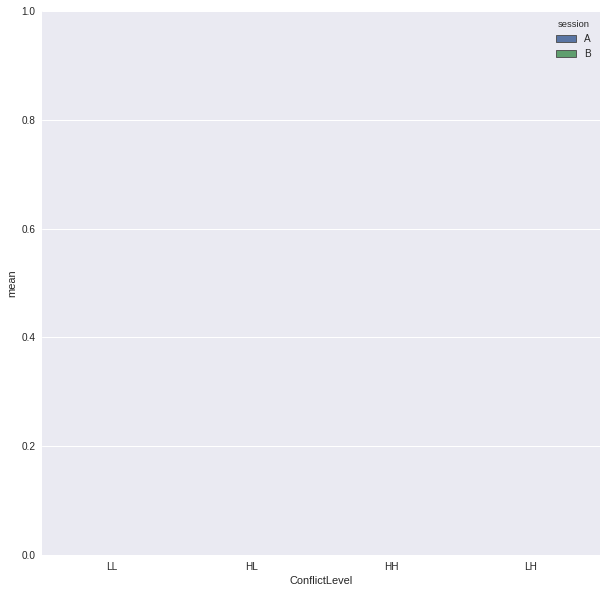

In [18]:
# IC CC CI II plots
def Graton (DataFrame, participant,condition):
  CC =  DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == participant) & (DataFrame.ConflictLevel == 'LL') & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['RT']
  CI = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == participant) & (DataFrame.ConflictLevel == 'LH') & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['RT']
  IC = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == participant) & (DataFrame.ConflictLevel == 'HL') & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['RT']
  II = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == participant) & (DataFrame.ConflictLevel == 'HH') & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['RT']  
  return CC, CI, IC, II


def GratonDF(DataFrame, condition):
  participantlist = DataFrame.participant.unique()    
  CC, CI, IC, II = Graton(DataFrameComplete,participantlist[0],condition)
  
  cc = {participantlist[0] : pd.Series(CC.tolist())}
  df_CC = pd.DataFrame(cc)
  ci = {participantlist[0] : pd.Series(CI.tolist())}
  df_CI = pd.DataFrame(ci)    
  ic = {participantlist[0] : pd.Series(IC.tolist())}
  df_IC = pd.DataFrame(ic) 
  ii = {participantlist[0] : pd.Series(II.tolist())}
  df_II = pd.DataFrame(ii)
    
  for y in participantlist[1:]:        
    CC, CI, IC, II = Graton(DataFrameComplete,y,condition)
    cc = {y : pd.Series(CC.tolist())}
    ci = {y : pd.Series(CI.tolist())}
    ic = {y : pd.Series(IC.tolist())}
    ii = {y : pd.Series(II.tolist())}
    cc = pd.DataFrame(cc)
    ci = pd.DataFrame(ci)
    ic = pd.DataFrame(ic)
    ii = pd.DataFrame(ii)
    df_CC = pd.concat([df_CC,cc], axis =1)  
    df_CI = pd.concat([df_CI,ci], axis =1)  
    df_IC = pd.concat([df_IC,ic], axis =1)  
    df_II = pd.concat([df_II,ii], axis =1)  
    
    
  df_CC['mean'] = df_CC.mean(axis=1, skipna = True)
  df_CI['mean'] = df_CI.mean(axis=1, skipna = True)
  df_IC['mean'] = df_IC.mean(axis=1, skipna = True)
  df_II['mean'] = df_II.mean(axis=1, skipna = True)
    
  df_CC['std'] = df_CC.std(axis=1, skipna = True)
  df_CI['std'] = df_CI.std(axis=1, skipna = True)
  df_IC['std'] = df_IC.std(axis=1, skipna = True)
  df_II['std'] = df_II.std(axis=1, skipna = True)    

  df_CC.loc['meanCC'] = df_CC.mean(skipna = True)
  df_CI.loc['meanCI'] = df_CI.mean(skipna = True)
  df_IC.loc['meanIC'] = df_IC.mean(skipna = True)
  df_II.loc['meanII'] = df_II.mean(skipna = True)
    
  df_CC['ConflictLevel'] = 'LL'
  df_CI['ConflictLevel'] = 'LH'
  df_IC['ConflictLevel'] = 'HL'
  df_II['ConflictLevel'] = 'HH'


    
    
  DF =  pd.concat([df_CC,df_CI,df_IC,df_II], axis =0)  
    
  return DF

def meanGraton(DataFrame):
  DF_A = GratonDF(DataFrame,'A')
  DF_B = GratonDF(DataFrame,'B')
    
  DF_A['session'] = 'A'
  DF_B['session'] = 'B'
  DF = pd.concat([DF_A,DF_B],axis=0)

  return DF

DF = meanGraton(DataFrameComplete.loc[DataFrameComplete.RT <= 1])


plt.figure(figsize=(10, 10))

plotted = sns.violinplot(y="mean", x = "ConflictLevel", hue ='session', data = DF, 
            order=['LL','HL','HH','LH'], hue_order = ['A','B']
          );



In [316]:
DataFrameComplete

linecolor    TrialType  corrAns  NofTrial       ISI Response        RT  \
106       GREEN    congruent      2.0       0.0  10.00000        1  0.834837   
107       GREEN    congruent      2.0       1.0   0.60295        1  0.590948   
108        BLUE  incongruent      3.0       2.0   0.65782        1  0.842361   
109      YELLOW    congruent      3.0       3.0   0.37575        1  0.691485   
110        BLUE  incongruent      3.0       4.0   0.59359        1  0.823725   
111       GREEN  incongruent      2.0       5.0   0.69992        1  0.714757   
112        BLUE  incongruent      3.0       6.0   0.64979        1  0.710633   
113       GREEN  incongruent      2.0       7.0   0.39149        1  0.775869   
114       GREEN  incongruent      2.0       8.0   0.30145        1  0.676785   
115         RED  incongruent      2.0       9.0   0.31533        1  0.835561   
116        BLUE    congruent      3.0      10.0   0.41019        1  0.630994   
117      YELLOW  incongruent      3.0      11.0   0.38112        1  0.554523   
118       GREEN  incongruent      2.0      12.0   0.58408        1  0.901276   
119        BLUE  incongruent      3.0      13.0   0.39149        1  0.591791   
120        BLUE  incongruent      3.0      14.0   0.31100        1  0.686470   
121      YELLOW  incongruent      3.0      15.0   0.55602        1  0.552079   
122         RED  incongruent      2.0      16.0   0.41606        1  1.083363   
123      YELLOW    congruent      3.0      17.0   0.39149        1  0.821117   
124         RED    congruent      2.0      18.0   0.45577        1  0.672648   
125      YELLOW    congruent      3.0      19.0   0.31482        1  0.541137   
126       GREEN  incongruent      2.0      20.0   0.31533        1  1.147031   
127       GREEN  incongruent      2.0      21.0   0.30145        1  0.605186   
128       GREEN    congruent      2.0      22.0   0.55167        1  0.495385   
129         RED    congruent      2.0      23.0   0.67007        1  0.673828   
130       GREEN  incongruent      2.0      24.0   0.37249        1  0.543388   
131        BLUE  incongruent      3.0      25.0   0.34332        1  0.661612   
132        BLUE  incongruent      3.0      26.0   0.31482        1  0.555577   
133      YELLOW    congruent      3.0      27.0   0.60055        1  0.481238   
134         RED  incongruent      2.0      28.0   0.55602        1  0.653388   
135      YELLOW    congruent      3.0      29.0   0.43134        1  0.787475   
...         ...          ...      ...       ...       ...      ...       ...   
11655      BLUE    congruent      3.0     571.0   0.59359        1  0.441435   
11656      BLUE    congruent      3.0     572.0   0.38368        1  0.524763   
11657       RED    congruent      2.0     573.0   0.59133        1  0.757693   
11658    YELLOW    congruent      3.0     574.0   0.42924        1  0.513594   
11659    YELLOW    congruent      3.0     575.0   0.64979        1  0.369187   
11660     GREEN  incongruent      2.0     576.0   0.48307        1  0.489167   
11661      BLUE    congruent      3.0     577.0   0.46005        1  0.524773   
11662     GREEN  incongruent      2.0     578.0   0.52129        1  0.490436   
11663      BLUE  incongruent      3.0     579.0   0.31482        1  0.430383   
11664       RED  incongruent      2.0     580.0   0.51807        1  0.490844   
11665    YELLOW  incongruent      3.0     581.0   0.58569        1  0.564845   
11666    YELLOW  incongruent      3.0     582.0   0.31613        1  0.479518   
11667      BLUE    congruent      3.0     583.0   0.43171        1  0.657828   
11668       RED  incongruent      2.0     584.0   0.58187        1  0.415039   
11669    YELLOW    congruent      3.0     585.0   0.40637        1  0.466570   
11670      BLUE    congruent      3.0     586.0   0.36382        1  0.464854   
11671       RED    congruent      2.0     587.0   0.31100        1  0.382242   
11672     GREEN  incongruent      2.0     588.0   0.50404        1  0.670620   
11673 

In [53]:
DF =DataFrameComplete

In [19]:
# RTs
def RTextraction (DataFrame, participant,condition):
  CongruentRTs =  DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == participant) & (DataFrame.TrialType == 'congruent') & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['RT']
  IncongruentRTs = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == participant) & (DataFrame.TrialType == 'incongruent') & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['RT']
  return CongruentRTs,IncongruentRTs


def RToverall(DataFrame, condition):
  participantlist = DataFrame.participant.unique()    
  CC,II = RTextraction(DataFrame,participantlist[0],condition)
  
  cc = {participantlist[0] : pd.Series(CC.tolist())}
  df_CC = pd.DataFrame(cc)
  ii = {participantlist[0] : pd.Series(II.tolist())}
  df_II = pd.DataFrame(ii)
    
  for y in participantlist[1:]:        
    CC, II = RTextraction(DataFrame,y,condition)
    cc = {y : pd.Series(CC.tolist())}
    ii = {y : pd.Series(II.tolist())}
    cc = pd.DataFrame(cc)

    ii = pd.DataFrame(ii)
    df_CC = pd.concat([df_CC,cc], axis =1)   
    df_II = pd.concat([df_II,ii], axis =1)  
    
    
#  df_CC['mean'] = df_CC.mean(axis=1, skipna = True)
#  df_II['mean'] = df_II.mean(axis=1, skipna = True)

    
  df_CC.loc['meanCongruent'+condition] = df_CC.mean(skipna = True)
  df_II.loc['meanIncongruent'+condition] = df_II.mean(skipna = True)
    
#  df_CC['std'] = df_CC.std(axis=1, skipna = True)
#  df_II['std'] = df_II.std(axis=1, skipna = True)    


  df_CC.loc['stdCongruent'+condition] = df_CC.std(skipna = True)
  df_II.loc['stdIncongruent'+condition] = df_II.std(skipna = True)    

  df_CC.loc['SEMCongruent'+condition] = df_CC.std(skipna = True) / math.sqrt(len(df_CC)-2)
  df_II.loc['SEMIncongruent'+condition] = df_II.std(skipna = True) / math.sqrt(len(df_II)-2)      
    
#  df_CC['Congruency'] = 'Congruent'
#  df_II['Congruency'] = 'Incongruent'


    
    
  DF =  pd.concat([df_CC,df_II], axis =0)  
    
  return DF


def RT_all(DataFrame):
  DF_A = RToverall(DataFrame,'A')
  DF_B = RToverall(DataFrame,'B')
    
#  DF_A['session'] = 'A'
#  DF_B['session'] = 'B'
  DF = pd.concat([DF_A,DF_B],axis=0)

  return DF



toplot = DataFrameComplete.loc[DataFrameComplete.RT <= 1]

DF = RT_all(toplot)


#plt.figure()
#plt.errorbar(xA, yA,fmt = 'bo',yerr=SerrorMA)
#plt.errorbar(xB,yB,fmt = 'go',yerr=SerrorMB)
#plt.show()

#plt.figure(figsize=(10, 10))

#plotted = sns.violinplot(y="mean", x = "ConflictLevel", hue ='session', data = DF, 
#            order=['LL','HL','HH','LH'], hue_order = ['A','B']
#          );
#DataFrame = DataFrameComplete
#condition = 'A'
#participant = 'SMRI1'
#DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == participant) & (DataFrame.TrialType == 'congruent') & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['RT']


DF.loc['meanCongruentA']

sdlpfc10   NaN
sdlpfc11   NaN
sdlpfc1    NaN
sdlpfc2    NaN
sdlpfc3    NaN
sdlpfc4    NaN
sdlpfc5    NaN
sdlpfc6    NaN
sdlpfc8    NaN
sdlpfc9    NaN
Name: meanCongruentA, dtype: float64

In [54]:
a = DF.loc['meanCongruentA'].tolist()
b = DF.loc['SEMCongruentA'].tolist()
plt.figure()
#plt.errorbar([1 for i in range(0,8)],a[0:8],fmt = 'bo',yerr=b[0:8])
a = DF.loc['meanIncongruentA'].tolist()
b = DF.loc['SEMIncongruentA'].tolist()
#plt.errorbar([2 for i in range(0,8)],a[0:8],fmt = 'bo',yerr=b[0:8])
a = DF.loc['meanCongruentB'].tolist()
b = DF.loc['SEMCongruentB'].tolist()
#plt.errorbar([3 for i in range(0,8)],a[0:8],fmt = 'bo',yerr=b[0:8])
a = DF.loc['meanIncongruentB'].tolist()
b = DF.loc['SEMIncongruentB'].tolist()
#plt.errorbar([4 for i in range(0,8)],a[0:8],fmt = 'bo',yerr=b[0:8])

# umgestalten der Daten:

RT = {'RT' : pd.Series(DF.loc['meanCongruentA'].tolist()+DF.loc['meanIncongruentA'].tolist()+DF.loc['meanCongruentB'].tolist()+DF.loc['meanIncongruentB'].tolist())}
df_RT = pd.DataFrame(RT)
session = {'session': pd.Series(['A' for i in range(0,16)]+['B' for i in range(0,16)])}
SESSION = pd.DataFrame(session)
congruency = {'TrialType': pd.Series(['congruent' for i in range(0,8)]+['incongruent' for i in range(0,8)]+['congruent' for i in range(0,8)]+['incongruent' for i in range(0,8)])}
CONGRUENCY = pd.DataFrame(congruency)

df_RT = pd.concat([df_RT,SESSION,CONGRUENCY], axis =1)  
print(df_RT)


seaborn.boxplot(y="RT", x = "TrialType", hue = 'session', data = df_RT, 
            order=['congruent','incongruent'], hue_order = ['A','B'],
           );

DF.loc['meanIncongruentA'].mean()
DF.loc['meanIncongruentB'].mean()

KeyError: 'the label [meanCongruentA] is not in the [index]'

In [34]:
# DO NOT


# Makes new Panda series to see which session was first (learned first)
DataFrameComplete = DataFrameComplete.assign(LearningDay = 'undefined')


# makes list of all availables subject numbers
forlooplist = []
for i in range(0,100):
    if any( DataFrameComplete.participant == (StudyName + '-' + str(i)) ):
        forlooplist.append(i)

        
# loops through all subjects        
for i in forlooplist: 
# the if structure gives every session a chronological number
  if DataFrameComplete.loc[(DataFrameComplete.participant == (StudyName + '-' + str(i))) & (DataFrameComplete.session == 'sham_Day1')].Datum.iloc[0] < DataFrameComplete.loc[(DataFrameComplete.participant == (StudyName + '-' + str(i))) & (DataFrameComplete.session == 'verum_Day1')].Datum.iloc[0]: 
      DataFrameComplete.loc[(DataFrameComplete.participant == (StudyName + '-' + str(i))) & (DataFrameComplete.session =='sham_Day1'), 'LearningDay'] = 1
      DataFrameComplete.loc[(DataFrameComplete.participant == (StudyName + '-' + str(i))) & (DataFrameComplete.session =='sham_Day2'), 'LearningDay'] = 2
      DataFrameComplete.loc[(DataFrameComplete.participant == (StudyName + '-' + str(i))) & (DataFrameComplete.session =='verum_Day1'), 'LearningDay'] = 3
      DataFrameComplete.loc[(DataFrameComplete.participant == (StudyName + '-' + str(i))) & (DataFrameComplete.session =='verum_Day2'), 'LearningDay'] = 4    
  else:
      DataFrameComplete.loc[(DataFrameComplete.participant == (StudyName + '-' + str(i))) & (DataFrameComplete.session =='sham_Day1'), 'LearningDay'] = 3
      DataFrameComplete.loc[(DataFrameComplete.participant == (StudyName + '-' + str(i))) & (DataFrameComplete.session =='sham_Day2'), 'LearningDay'] = 4
      DataFrameComplete.loc[(DataFrameComplete.participant == (StudyName + '-' + str(i))) & (DataFrameComplete.session =='verum_Day1'), 'LearningDay'] = 1
      DataFrameComplete.loc[(DataFrameComplete.participant == (StudyName + '-' + str(i))) & (DataFrameComplete.session =='verum_Day2'), 'LearningDay'] = 2  
#DataFrameComplete.loc[(DataFrameComplete.participant == participant) & (DataFrameComplete.session == 'sham_Day1')].Datum.iloc[0]


#DataFrameComplete.tail()
DataFrameComplete['LearningDay'].value_counts()
DataFrameComplete.tail()

linecolor  TrialType  corrAns  NofTrial      ISI Response        RT  \
701       RED  congruent      2.0     595.0  0.35795        1  0.624413   
702       RED  congruent      2.0     596.0  0.47163        1  0.406121   
703    YELLOW  congruent      3.0     597.0  0.40637        1  0.567673   
704     GREEN  congruent      2.0     598.0  0.31533        1  0.884938   
705       RED  congruent      2.0     599.0  0.37320        1  0.830930   

                 date  Framerate Experiment session participant ConflictLevel  \
701  2017_Okt_17_1330  98.155242     Stroop      1A       SMRI1      20171017   
702  2017_Okt_17_1330  98.155242     Stroop      1A       SMRI1      20171017   
703  2017_Okt_17_1330  98.155242     Stroop      1A       SMRI1      20171017   
704  2017_Okt_17_1330  98.155242     Stroop      1A       SMRI1      20171017   
705  2017_Okt_17_1330  98.155242     Stroop      1A       SMRI1      20171017   

         Datum LearningDay  
701  undefined   undefined  
702  undefined   undefined  
703  undefined   undefined  
704  undefined   undefined  
705  undefined   undefined

In [20]:
toplot = DataFrameComplete.loc[(DataFrameComplete.RT <= 1) ]#& (DataFrameComplete.participant == 'SMRI2')]

A = getRTsGeneral(DataFrameComplete.loc[(DataFrameComplete.RT <= 1) ],'A') 
print(A.mean())
B = getRTsGeneral(DataFrameComplete.loc[(DataFrameComplete.RT <= 1) ],'B')
print(B.mean())

Congruent, Incongruent = getRTmeanSTD(toplot,'A')
print('divider')
getRTmeanSTD(toplot,'B')

Congruent

NameError: name 'getRTsGeneral' is not defined

In [35]:
DataFrameCompleteAuswertung = DataFrameComplete

participant = 'sdlpfc11'
ARTFCITIV = DataFrameCompleteAuswertung.loc[  (DataFrameCompleteAuswertung.Response ==1) & (DataFrameCompleteAuswertung.session == 'verum') & (DataFrameCompleteAuswertung.TrialType == 'incongruent')].RT.mean()
print('average RT for correct incongruent trials in verum', ARTFCITIV)
ARTFCCTIV = DataFrameCompleteAuswertung.loc[  (DataFrameCompleteAuswertung.Response ==1) & (DataFrameCompleteAuswertung.session == 'verum') & (DataFrameCompleteAuswertung.TrialType == 'congruent')].RT.mean()
print('average RT for correct congruent trials in verum', ARTFCCTIV)
print('Stroop effect in verum', ARTFCITIV-ARTFCCTIV )

ARTFCITIS = DataFrameCompleteAuswertung.loc[ (DataFrameCompleteAuswertung.Response ==1) & (DataFrameCompleteAuswertung.session == 'sham') & (DataFrameCompleteAuswertung.TrialType == 'incongruent')].RT.mean()
print('average RT for correct incongruent trials in sham', ARTFCITIS)
ARTFCCTIS = DataFrameCompleteAuswertung.loc[(DataFrameCompleteAuswertung.Response ==1) & (DataFrameCompleteAuswertung.session == 'sham') & (DataFrameCompleteAuswertung.TrialType == 'congruent')].RT.mean()
print('average RT for correct congruent trials in sham', ARTFCCTIS)
print('Stroop effect in sham', ARTFCITIS-ARTFCCTIS )
print ((ARTFCITIV-ARTFCCTIV) < (ARTFCITIS-ARTFCCTIS))

average RT for correct incongruent trials in verum 0.640208416406
average RT for correct congruent trials in verum 0.600238158136
Stroop effect in verum 0.0399702582705
average RT for correct incongruent trials in sham 0.64792277159
average RT for correct congruent trials in sham 0.603114071979
Stroop effect in sham 0.0448086996114
True


In [ ]:
# running mixed linear model
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])

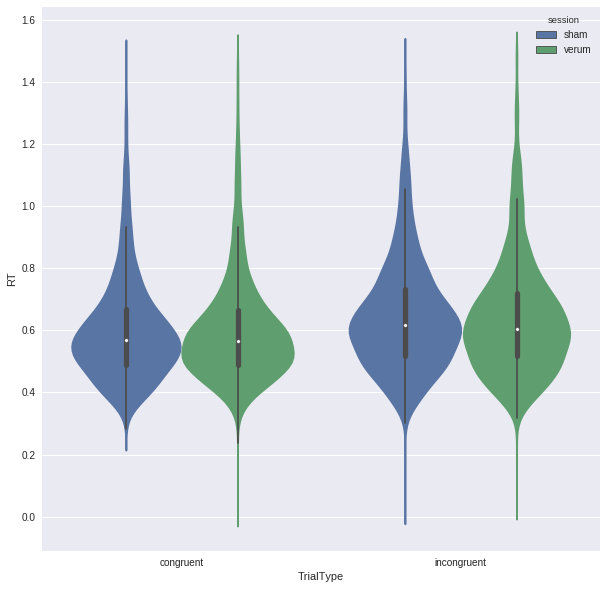

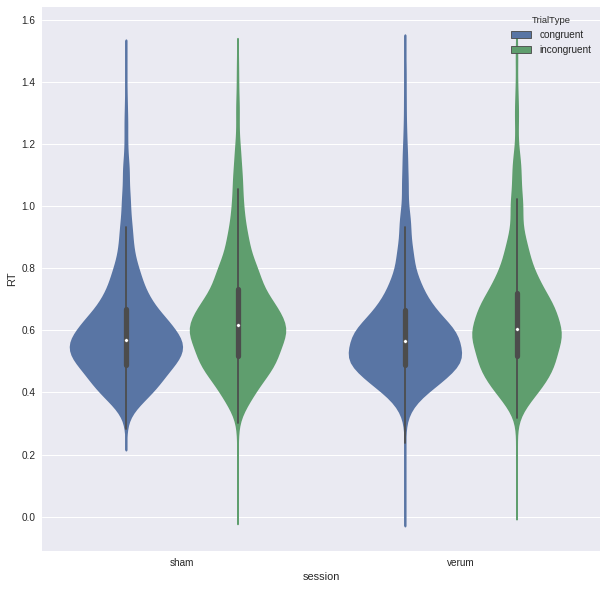

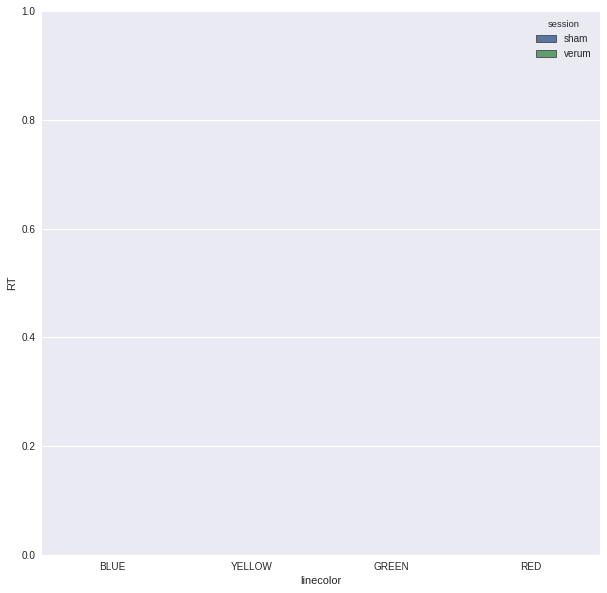

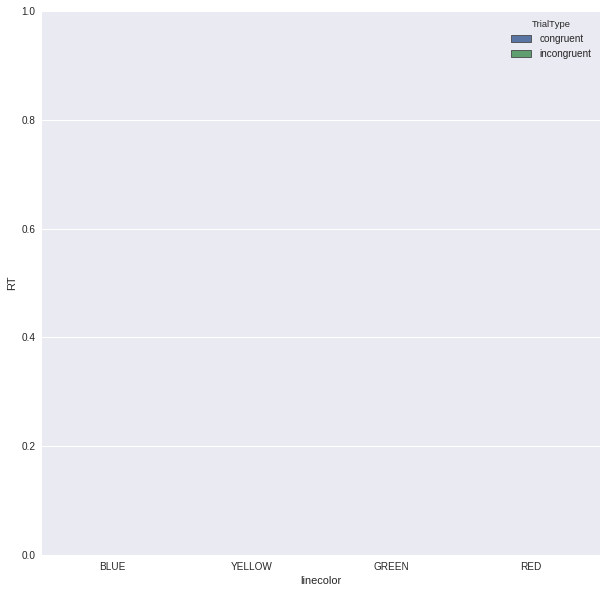

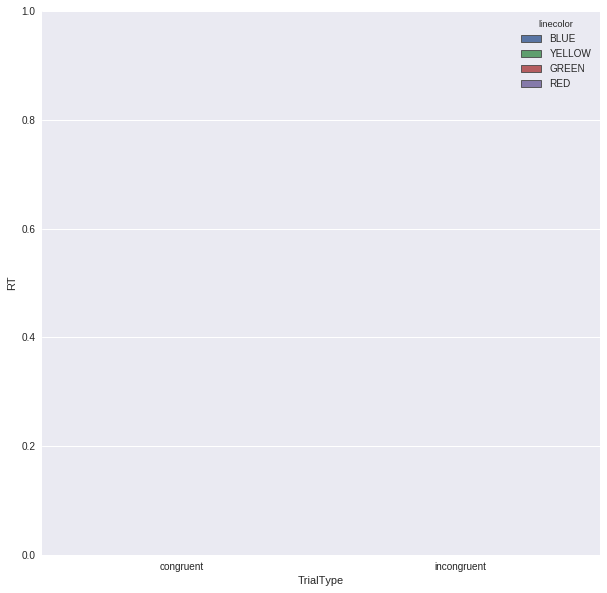

<function seaborn.categorical.boxplot>

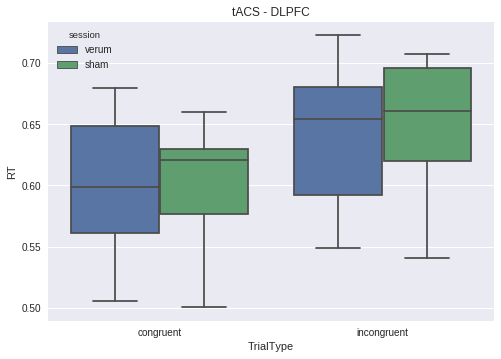

In [28]:
seaborn.boxplot(x="TrialType", y = "RT", hue = "session", data = DataFrameDotplot.loc[(DataFrameDotplot.RT < 1.5) & (DataFrameDotplot.RT > 0.3)], 
                   order = ['congruent','incongruent'], hue_order = ['verum','sham']
                  ).set_title('tACS - DLPFC')
DataFrameDotplot
seaborn.boxplot

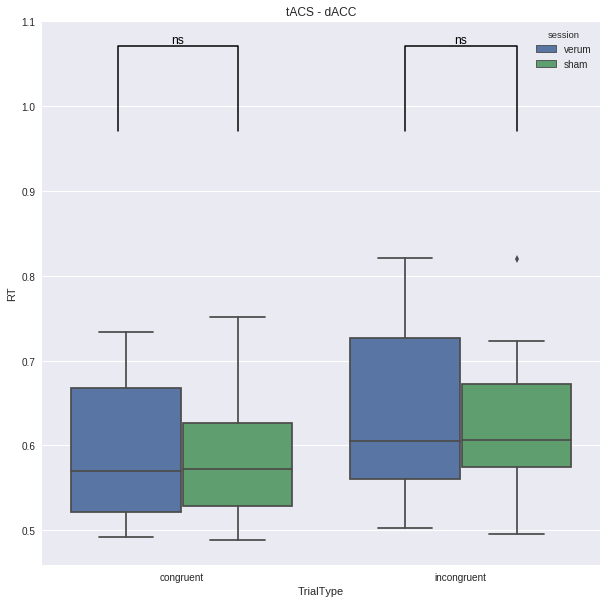

In [58]:
# here the mean value per participant / session / congruency type is computed.
# So there are only as many data points per boxplot as there are participants


# here we make a DataFrame with the mean values
RT = []
session = []
TrialType = []
participant = []
for f in DataFrameComplete.session.unique():
  for j in DataFrameComplete.participant.unique():
    for i in DataFrameComplete.TrialType.unique():
      RT.append(DataFrameComplete[(DataFrameComplete.TrialType == i) & (DataFrameComplete.Response == 1.0) & (DataFrameComplete.participant == j) & (DataFrameComplete.session == f)].RT.mean())
      session.append(f)
      TrialType.append(i)
      participant.append(j)
RT = pd.Series(RT)
session = pd.Series(session)
TrialType = pd.Series(TrialType)
participant = pd.Series(participant)


DataFrameDotplot = pd.DataFrame({'RT': RT,
                                 'session': session,
                                 'TrialType': TrialType,
                                 'participant': participant})


# and now we use the new DataFrame to make a figure

plt.figure(figsize=(10, 10))


if 'sdlpfc' in DataFrameDotplot.participant.unique()[0]:
  seaborn.boxplot(x="TrialType", y = "RT", hue = "session", data = DataFrameDotplot.loc[(DataFrameDotplot.RT < 1.5) & (DataFrameDotplot.RT > 0.3)], 
                   order = ['congruent','incongruent'], hue_order = ['verum','sham']
                  ).set_title('tACS - DLPFC')
else:
    seaborn.boxplot(x="TrialType", y = "RT", hue = "session", data = DataFrameDotplot.loc[(DataFrameDotplot.RT < 1.5) & (DataFrameDotplot.RT > 0.3)], 
                   order = ['congruent','incongruent'], hue_order = ['verum','sham']
                  ).set_title('tACS - dACC')     


x1, x2 = 0.8, 1.2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = DataFrameDotplot['RT'].max() + 0.15, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

x1, x2 = -0.23, 0.20  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, h, col = DataFrameDotplot['RT'].max() + 0.15, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)

#x1, x2 = 1.8, 2.2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
#y, h, col = DataFrameDotplot['RT'].max() + 0.15, 0.1, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)




plt.show()

In [24]:
len(DataFrameComplete.loc[(DataFrameComplete.participant == 'Till') & (DataFrameComplete.RT > 1.2)])
DataFrameComplete.loc[DataFrameComplete.date == '2017_Okt_06_1131']

0

In [332]:
DataFrameComplete[(DataFrameComplete.linecolor == 'RED')&(DataFrameComplete.TrialType == 'incongruent')  ].RT.mean()
DataFrameComplete

linecolor    TrialType  corrAns  NofTrial       ISI Response        RT  \
106     GREEN    congruent      2.0       0.0  10.00000        1  0.834837   
107     GREEN    congruent      2.0       1.0   0.60295        1  0.590948   
108      BLUE  incongruent      3.0       2.0   0.65782        1  0.842361   
109    YELLOW    congruent      3.0       3.0   0.37575        1  0.691485   
110      BLUE  incongruent      3.0       4.0   0.59359        1  0.823725   
111     GREEN  incongruent      2.0       5.0   0.69992        1  0.714757   
112      BLUE  incongruent      3.0       6.0   0.64979        1  0.710633   
113     GREEN  incongruent      2.0       7.0   0.39149        1  0.775869   
114     GREEN  incongruent      2.0       8.0   0.30145        1  0.676785   
115       RED  incongruent      2.0       9.0   0.31533        1  0.835561   
116      BLUE    congruent      3.0      10.0   0.41019        1  0.630994   
117    YELLOW  incongruent      3.0      11.0   0.38112        1  0.554523   
118     GREEN  incongruent      2.0      12.0   0.58408        1  0.901276   
119      BLUE  incongruent      3.0      13.0   0.39149        1  0.591791   
120      BLUE  incongruent      3.0      14.0   0.31100        1  0.686470   
121    YELLOW  incongruent      3.0      15.0   0.55602        1  0.552079   
122       RED  incongruent      2.0      16.0   0.41606        1  1.083363   
123    YELLOW    congruent      3.0      17.0   0.39149        1  0.821117   
124       RED    congruent      2.0      18.0   0.45577        1  0.672648   
125    YELLOW    congruent      3.0      19.0   0.31482        1  0.541137   
126     GREEN  incongruent      2.0      20.0   0.31533        1  1.147031   
127     GREEN  incongruent      2.0      21.0   0.30145        1  0.605186   
128     GREEN    congruent      2.0      22.0   0.55167        1  0.495385   
129       RED    congruent      2.0      23.0   0.67007        1  0.673828   
130     GREEN  incongruent      2.0      24.0   0.37249        1  0.543388   
131      BLUE  incongruent      3.0      25.0   0.34332        1  0.661612   
132      BLUE  incongruent      3.0      26.0   0.31482        1  0.555577   
133    YELLOW    congruent      3.0      27.0   0.60055        1  0.481238   
134       RED  incongruent      2.0      28.0   0.55602        1  0.653388   
135    YELLOW    congruent      3.0      29.0   0.43134        1  0.787475   
..        ...          ...      ...       ...       ...      ...       ...   
676       RED  incongruent      2.0     570.0   0.37497        1  0.629067   
677     GREEN    congruent      2.0     571.0   0.59359        0  1.118206   
678    YELLOW    congruent      3.0     572.0   0.38368        1  0.493699   
679     GREEN    congruent      2.0     573.0   0.59133        1  0.651019   
680    YELLOW    congruent      3.0     574.0   0.42924        1  0.591151   
681     GREEN    congruent      2.0     575.0   0.64979        1  0.638777   
682      BLUE  incongruent      3.0     576.0   0.48307        1  0.930833   
683    YELLOW    congruent      3.0     577.0   0.46005        0  0.971715   
684    YELLOW  incongruent      3.0     578.0   0.52129        1  0.516677   
685       RED  incongruent      2.0     579.0   0.31482        1  1.009212   
686      BLUE  incongruent      3.0     580.0   0.51807        1  1.147858   
687     GREEN  incongruent      2.0     581.0   0.58569        1  1.206052   
688    YELLOW  incongruent      3.0     582.0   0.31613        1  1.056793   
689      BLUE    congruent      3.0     583.0   0.43171        1  1.221005   
690     GREEN  incongruent      2.0     584.0   0.58187        1  0.886576   
691      BLUE    congruent      3.0     585.0   0.40637        1  0.865251   
692     GREEN    congruent      2.0     586.0   0.36382        1  0.677676   
693    YELLOW    congruent      3.0     587.0   0.31100        1  0.909394   
694    YELLOW  incongruent      3.0     588.0   0.50404        1  0.873594   
695    YELLOW    congruent

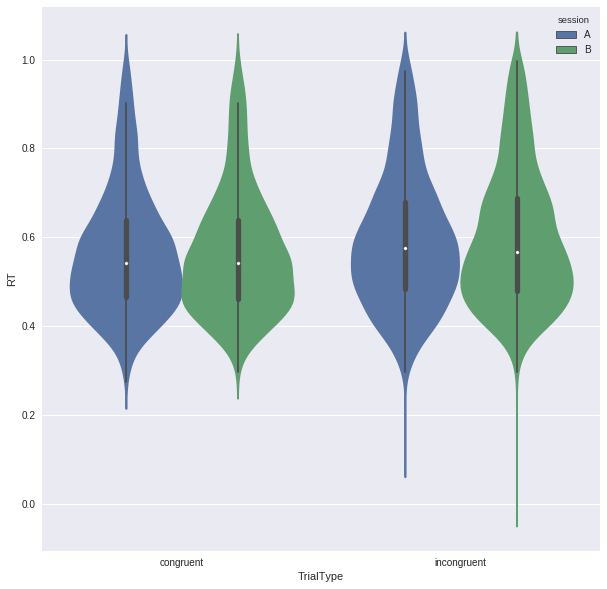

In [145]:
plt.figure(figsize=(10, 10))

plotted = sns.violinplot(y="RT", x = "TrialType", hue = 'session' ,data = DataFrameComplete.loc[DataFrameComplete.RT <= 1], 
            order=['congruent','incongruent'] , hue_order = ['A','B']
           );

linecolor    TrialType  corrAns  NofTrial       ISI Response        RT  \
106     GREEN    congruent      2.0       0.0  10.00000        1  0.834837   
107     GREEN    congruent      2.0       1.0   0.60295        1  0.590948   
108      BLUE  incongruent      3.0       2.0   0.65782        1  0.842361   
109    YELLOW    congruent      3.0       3.0   0.37575        1  0.691485   
110      BLUE  incongruent      3.0       4.0   0.59359        1  0.823725   

                 date  Framerate Experiment session participant ConflictLevel  \
106  2017_Okt_17_1330  98.155242     Stroop       A       SMRI1            LL   
107  2017_Okt_17_1330  98.155242     Stroop       A       SMRI1            LL   
108  2017_Okt_17_1330  98.155242     Stroop       A       SMRI1            LH   
109  2017_Okt_17_1330  98.155242     Stroop       A       SMRI1            HL   
110  2017_Okt_17_1330  98.155242     Stroop       A       SMRI1            LH   

         Datum  
106  undefined  
107  undefined  
108  undefined  
109  undefined  
110  undefined

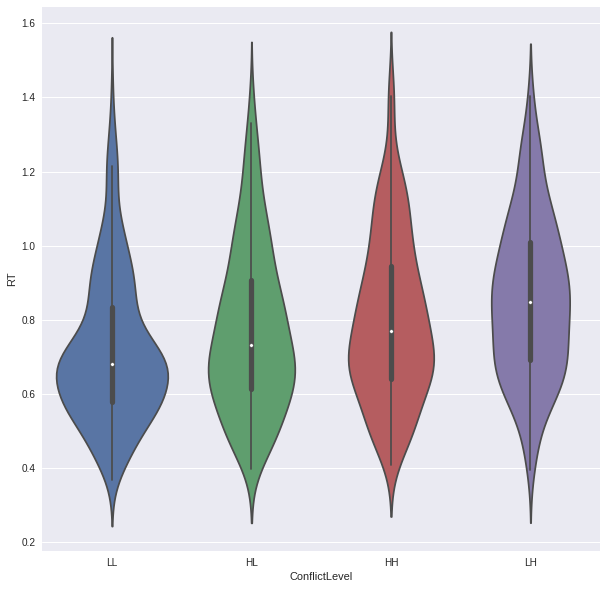

In [192]:
plt.figure(figsize=(10, 10))

plotted = sns.violinplot(y="RT", x = "ConflictLevel", data = DataFrameComplete[DataFrameComplete.participant == 'SMRI1'], 
            order=['LL','HL','HH','LH',] , 
           );
DataFrameComplete.head()

In [105]:
# differentes between HL, LL, HH, LH

minuendHL = DataFrameComplete[(DataFrameComplete["TrialType"] == 'congruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'HL')]["RT"].mean()

subtrahendHL = DataFrameComplete[(DataFrameComplete["TrialType"] == 'congruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'HL') ]["RT"].mean()
difference = minuendHL - subtrahendHL
print('HL - difference between tacs - sham',difference)

minuendLH = DataFrameComplete[(DataFrameComplete["TrialType"] == 'incongruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'LH')]["RT"].mean()

subtrahendLH = DataFrameComplete[(DataFrameComplete["TrialType"] == 'incongruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'LH') ]["RT"].mean()
difference = minuendLH - subtrahendLH
print('LHverumSham',difference)

print('verum stimulation LH',minuendLH)

print('sham stimulation LH',subtrahendLH)

minuendHH = DataFrameComplete[(DataFrameComplete["TrialType"] == 'incongruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'HH')]["RT"].mean()

subtrahendHH = DataFrameComplete[(DataFrameComplete["TrialType"] == 'incongruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'HH')]["RT"].mean()
difference = minuendHH - subtrahendHH
print('HHverumSham',difference)

minuendLL = DataFrameComplete[(DataFrameComplete["TrialType"] == 'congruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'LL')]["RT"].mean()

subtrahendLL = DataFrameComplete[(DataFrameComplete["TrialType"] == 'congruent' ) 
                  & (DataFrameComplete["ConflictLevel"] == 'LL')]["RT"].mean()
difference = minuendLL - subtrahendLL
print('LL - difference between tacs - sham',difference)

print('verum stimulation HH',minuendHH)

print('sham stimulation HH',subtrahendHH)

incongruentVerum = DataFrameComplete[(DataFrameComplete["TrialType"] == 'congruent')  
                                    ]["RT"].mean()



print ('incongruentVerum', incongruentVerum)

congruentVerum = DataFrameComplete[(DataFrameComplete["TrialType"] == 'congruent' )  
                  ]["RT"].mean()



print ('congruentVerum', congruentVerum)

print(minuendHH, minuendHL)
print ('Conflict detection cI - cC: tacs:', minuendLH - minuendLL )
print ('Conflict adaptation iI - iC: tacs:', minuendHH - minuendHL)
print ('LH - HH', minuendLH, minuendHH, minuendLH - minuendHH)
print ('HL - LL', minuendHL, minuendLL, minuendHL - minuendLL)
# congruency sequence effect: [cI - CC]-[iI iC]
print ('congruency sequence effect tacs' , (minuendLH - minuendLL) - (minuendHH - minuendHL))
print ('congruency sequence effect sham' , (subtrahendLH - subtrahendLL) - (subtrahendHH - subtrahendHL))


HL - difference between tacs - sham 0.0
LHverumSham 0.0
verum stimulation LH 0.525359236812
sham stimulation LH 0.525359236812
HHverumSham 0.0
LL - difference between tacs - sham 0.0
verum stimulation HH 0.490485497705
sham stimulation HH 0.490485497705
incongruentVerum 0.500049621312
congruentVerum 0.500049621312
0.490485497705 0.528140294557
Conflict detection cI - cC: tacs: 0.04708404269
Conflict adaptation iI - iC: tacs: -0.0376547968518
LH - HH 0.525359236812 0.490485497705 0.0348737391072
HL - LL 0.528140294557 0.478275194122 0.0498651004345
congruency sequence effect tacs 0.0847388395418
congruency sequence effect sham 0.0847388395418


In [65]:
minuendHL = DataFrameComplete[ (DataFrameComplete["TrialType"] == 'congruent' )   &
                               (DataFrameComplete["ConflictLevel"] == 'HL')]["RT"].mean()

In [66]:
minuendHH  

nan

In [67]:
minuendHL

nan

In [68]:
print(DataFrameComplete[(DataFrameComplete.RowNum == 'RED') &
                       (DataFrameComplete.participant == 'A')]['RT'].mean())
print(DataFrameComplete[(DataFrameComplete.RowNum == 'GREEN') &
                       (DataFrameComplete.participant == 'A')]['RT'].mean())
print(DataFrameComplete[(DataFrameComplete.RowNum == 'BLUE') &
                       (DataFrameComplete.participant == 'A')]['RT'].mean())

0.629082924128
0.713237088919
0.694212969184


In [69]:
print(DataFrameComplete[(DataFrameComplete.RowNum == 'RED') 
                       ]['RT'].mean())

print(DataFrameComplete[(DataFrameComplete.RowNum == 'GREEN') 
                       ]['RT'].mean())
print(DataFrameComplete[(DataFrameComplete.RowNum == 'BLUE') 
                       ]['RT'].mean())
DataFrameComplete.head()

0.659430062436
0.717117574081
0.745873250536


TrialType RowNum   Word  NofTrial   ITI  Correctness        RT  \
102    congruent    RED    RED       0.0  26.0          1.0  0.717548   
103    congruent  GREEN  GREEN       1.0  25.0          0.0  0.634069   
104  incongruent   BLUE  GREEN       2.0  31.0          1.0  0.767547   
105  incongruent    RED   BLUE       3.0  25.0          1.0  0.500408   
106    congruent  GREEN  GREEN       4.0  27.0          1.0  0.616921   

                 date  FrameRate ExperimentTitle  session participant  \
102  2017_Aug_18_1400  59.817196          Stroop        1           E   
103  2017_Aug_18_1400  59.817196          Stroop        1           E   
104  2017_Aug_18_1400  59.817196          Stroop        1           E   
105  2017_Aug_18_1400  59.817196          Stroop        1           E   
106  2017_Aug_18_1400  59.817196          Stroop        1           E   

    ConflictLevel      Datum LearningDay  
102      20170818  undefined   undefined  
103      20170818  undefined   undefined  
104      20170818  undefined   undefined  
105      20170818  undefined   undefined  
106      20170818  undefined   undefined

In [1]:
def distributions(DataFrame, Proband, condition):
  allcongruent_correct = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['RT']
  allincongruent_correct = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['RT']

  return  allcongruent_correct,allincongruent_correct


# Probandendaten zur DMC einspeisen
def DMCQuantiles (DataFrame, Proband,condition):
#Zielstruktur:
#data structure: 
#data[0]:     number of correct trials
#data[1]:     proportion correct
#data[2:7]:   .1, .3, .5, .7, .9 RT quantiles for correct trials (in ms)
#data[7]:     number of incorrect trials
#data[8]:     proportion of incorrect trials
#data[9:14]:  RT quantiles for incorrect trials (in ms). Because we have a number of errors > 10 in each congruency condition, .1, .3, .5 , .7, .9 RT quantiles are computed

  congruent_data = []
  congruent_data_lang = []

  NrCorrTrials = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['participant'].count()
  RatioCorr = NrCorrTrials / DataFrame[(DataFrame['session'].str.contains(condition))& (DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent')]['participant'].count()
  AllCongCorr = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['RT']

  NrInCorrTrials = DataFrame[(DataFrame['session'].str.contains(condition))&(DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrameComplete.Response == 0.0)]['participant'].count()
  RatioInCorr = NrInCorrTrials / DataFrame[(DataFrame['session'].str.contains(condition))& (DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent')]['participant'].count()
  AllInCongCorr = DataFrame[ (DataFrame['session'].str.contains(condition)) &(DataFrame.participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 0.0)]['RT']



  congruent_data.append(NrCorrTrials)
  congruent_data.append(RatioCorr)
  congruent_data.append(AllCongCorr.quantile(q=.1))
  congruent_data.append(AllCongCorr.quantile(q=.3))
  congruent_data.append(AllCongCorr.quantile(q=.5))
  congruent_data.append(AllCongCorr.quantile(q=.7))
  congruent_data.append(AllCongCorr.quantile(q=.9))
 
  congruent_data.append(NrInCorrTrials)
  congruent_data.append(RatioInCorr)
  congruent_data.append(AllInCongCorr.quantile(q=.1))
  congruent_data.append(AllInCongCorr.quantile(q=.3))
  congruent_data.append(AllInCongCorr.quantile(q=.5))
  congruent_data.append(AllInCongCorr.quantile(q=.7))
  congruent_data.append(AllInCongCorr.quantile(q=.9))

    
  congruent_data_lang.append(NrCorrTrials)
  congruent_data_lang.append(RatioCorr)
  congruent_data_lang.append(AllCongCorr.quantile(q=.1))
  congruent_data_lang.append(AllCongCorr.quantile(q=.2))
  congruent_data_lang.append(AllCongCorr.quantile(q=.3))
  congruent_data_lang.append(AllCongCorr.quantile(q=.4))
  congruent_data_lang.append(AllCongCorr.quantile(q=.5))
  congruent_data_lang.append(AllCongCorr.quantile(q=.6))
  congruent_data_lang.append(AllCongCorr.quantile(q=.7))
  congruent_data_lang.append(AllCongCorr.quantile(q=.8))
  congruent_data_lang.append(AllCongCorr.quantile(q=.9))
  congruent_data_lang.append(AllCongCorr.quantile(q= 1))
    
  congruent_data_lang.append(NrInCorrTrials)
  congruent_data_lang.append(RatioInCorr)
  congruent_data_lang.append(AllInCongCorr.quantile(q=.1))
  congruent_data_lang.append(AllInCongCorr.quantile(q=.2))
  congruent_data_lang.append(AllInCongCorr.quantile(q=.3))
  congruent_data_lang.append(AllInCongCorr.quantile(q=.4))
  congruent_data_lang.append(AllInCongCorr.quantile(q=.5))
  congruent_data_lang.append(AllInCongCorr.quantile(q=.6))
  congruent_data_lang.append(AllInCongCorr.quantile(q=.7))
  congruent_data_lang.append(AllInCongCorr.quantile(q=.8))
  congruent_data_lang.append(AllInCongCorr.quantile(q=.9))
  congruent_data_lang.append(AllInCongCorr.quantile(q= 1))


  print( RatioCorr + RatioInCorr == 1)

  incongruent_data = []
  incongruent_data_lang = []
    
  NrCorrTrials = DataFrame[(DataFrame['session'].str.contains(condition))& (DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['participant'].count()
  RatioCorr = NrCorrTrials / DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent')]['participant'].count()
  AllCongCorr = DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['RT']

  NrInCorrTrials = DataFrame[ (DataFrame['session'].str.contains(condition)) & (DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 0.0)]['participant'].count()
  RatioInCorr = NrInCorrTrials / DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent')]['participant'].count()
  AllInCongCorr = DataFrame[(DataFrame['session'].str.contains(condition)) & (DataFrame.participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 0.0)]['RT']

  incongruent_data.append(NrCorrTrials)
  incongruent_data.append(RatioCorr)
  incongruent_data.append(AllCongCorr.quantile(q=.1))
  incongruent_data.append(AllCongCorr.quantile(q=.3))
  incongruent_data.append(AllCongCorr.quantile(q=.5))
  incongruent_data.append(AllCongCorr.quantile(q=.7))
  incongruent_data.append(AllCongCorr.quantile(q=.9))

  incongruent_data.append(NrInCorrTrials)
  incongruent_data.append(RatioInCorr)
  incongruent_data.append(AllInCongCorr.quantile(q=.1))
  incongruent_data.append(AllInCongCorr.quantile(q=.3))
  incongruent_data.append(AllInCongCorr.quantile(q=.5))
  incongruent_data.append(AllInCongCorr.quantile(q=.7))
  incongruent_data.append(AllInCongCorr.quantile(q=.9))
 
  incongruent_data_lang.append(NrCorrTrials)
  incongruent_data_lang.append(RatioCorr)
  incongruent_data_lang.append(AllCongCorr.quantile(q=.1))
  incongruent_data_lang.append(AllCongCorr.quantile(q=.2))
  incongruent_data_lang.append(AllCongCorr.quantile(q=.3))
  incongruent_data_lang.append(AllCongCorr.quantile(q=.4))
  incongruent_data_lang.append(AllCongCorr.quantile(q=.5))
  incongruent_data_lang.append(AllCongCorr.quantile(q=.6))
  incongruent_data_lang.append(AllCongCorr.quantile(q=.7))
  incongruent_data_lang.append(AllCongCorr.quantile(q=.8))
  incongruent_data_lang.append(AllCongCorr.quantile(q=.9))
  incongruent_data_lang.append(AllCongCorr.quantile(q= 1))
    
  incongruent_data_lang.append(NrInCorrTrials)
  incongruent_data_lang.append(RatioInCorr)
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.1))
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.2))
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.3))
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.4))
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.5))
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.6))
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.7))
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.8))
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.9))
  incongruent_data_lang.append(AllInCongCorr.quantile(q= 1))

  print(RatioCorr + RatioInCorr == 1)
  return congruent_data, congruent_data_lang, incongruent_data, incongruent_data_lang



In [88]:
AllCongCorr = DataFrameComplete[(DataFrameComplete.participant == Proband) & (DataFrameComplete.TrialType == 'congruent') & (DataFrameComplete.Correctness == 1.0)]['RT']

In [104]:
a.quantile(q = 0.100)

0.5005712509152

In [128]:
print(congruent_data)
incongruent_data

[268, 0.89632107023411367, 0.5005712509152, 0.6023377656939, 0.667330980301, 0.7507240056996001, 0.9341481685636, 31, 0.10367892976588629, 0.6005809307100001, 0.684162855148, 0.7342469692229999, 0.8173151016240001, 1.0677480697600001]


[263,
 0.8915254237288136,
 0.5339045047759999,
 0.6507160186766,
 0.7508771419529999,
 0.8841467380526,
 1.067881822586,
 32,
 0.10847457627118644,
 0.5837085962294001,
 0.6273769617081999,
 0.7758790254595,
 0.8842793464663,
 1.0945235014000003]

0.9341481685636

In [612]:
# Probandendaten zur DMC einspeisen
def DMCQuantiles (DataFrame, Proband,condition):
#Zielstruktur:
#data structure: 
#data[0]:     number of correct trials
#data[1]:     proportion correct
#data[2:7]:   .1, .3, .5, .7, .9 RT quantiles for correct trials (in ms)
#data[7]:     number of incorrect trials
#data[8]:     proportion of incorrect trials
#data[9:14]:  RT quantiles for incorrect trials (in ms). Because we have a number of errors > 10 in each congruency condition, .1, .3, .5 , .7, .9 RT quantiles are computed

  congruent_data = []
  congruent_data_lang = []

  NrCorrTrials = DataFrame[(DataFrame['StimulationCondition'].str.contains(condition))&(DataFrame.Participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['Participant'].count()
  RatioCorr = NrCorrTrials / DataFrame[(DataFrame['StimulationCondition'].str.contains(condition))& (DataFrame.Participant == Proband) & (DataFrame.TrialType == 'congruent')]['Participant'].count()
  AllCongCorr = DataFrame[(DataFrame['StimulationCondition'].str.contains(condition))&(DataFrame.Participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 1.0)]['RT']

  NrInCorrTrials = DataFrame[(DataFrame['StimulationCondition'].str.contains(condition))&(DataFrame.Participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrameComplete.Response == 0.0)]['Participant'].count()
  RatioInCorr = NrInCorrTrials / DataFrame[(DataFrame['StimulationCondition'].str.contains(condition))& (DataFrame.Participant == Proband) & (DataFrame.TrialType == 'congruent')]['Participant'].count()
  AllInCongCorr = DataFrame[ (DataFrame['StimulationCondition'].str.contains(condition)) &(DataFrame.Participant == Proband) & (DataFrame.TrialType == 'congruent') & (DataFrame.Response == 0.0)]['RT']



  congruent_data.append(NrCorrTrials)
  congruent_data.append(RatioCorr)
  congruent_data.append(AllCongCorr.quantile(q=.1)*1000)
  congruent_data.append(AllCongCorr.quantile(q=.3)*1000)
  congruent_data.append(AllCongCorr.quantile(q=.5)*1000)
  congruent_data.append(AllCongCorr.quantile(q=.7)*1000)
  congruent_data.append(AllCongCorr.quantile(q=.9)*1000)
 
  congruent_data.append(NrInCorrTrials)
  congruent_data.append(RatioInCorr)
  congruent_data.append(AllInCongCorr.quantile(q=.1)*1000)
  congruent_data.append(AllInCongCorr.quantile(q=.3)*1000)
  congruent_data.append(AllInCongCorr.quantile(q=.5)*1000)
  congruent_data.append(AllInCongCorr.quantile(q=.7)*1000)
  congruent_data.append(AllInCongCorr.quantile(q=.9)*1000)

    
  congruent_data_lang.append(NrCorrTrials)
  congruent_data_lang.append(RatioCorr)
  congruent_data_lang.append(AllCongCorr.quantile(q=.1)*1000)
  congruent_data_lang.append(AllCongCorr.quantile(q=.2)*1000)
  congruent_data_lang.append(AllCongCorr.quantile(q=.3)*1000)
  congruent_data_lang.append(AllCongCorr.quantile(q=.4)*1000)
  congruent_data_lang.append(AllCongCorr.quantile(q=.5)*1000)
  congruent_data_lang.append(AllCongCorr.quantile(q=.6)*1000)
  congruent_data_lang.append(AllCongCorr.quantile(q=.7)*1000)
  congruent_data_lang.append(AllCongCorr.quantile(q=.8)*1000)
  congruent_data_lang.append(AllCongCorr.quantile(q=.9)*1000)
  congruent_data_lang.append(AllCongCorr.quantile(q= 1)*1000)
    
  congruent_data_lang.append(NrInCorrTrials)
  congruent_data_lang.append(RatioInCorr)
  congruent_data_lang.append(AllInCongCorr.quantile(q=.1)*1000)
  congruent_data_lang.append(AllInCongCorr.quantile(q=.2)*1000)
  congruent_data_lang.append(AllInCongCorr.quantile(q=.3)*1000)
  congruent_data_lang.append(AllInCongCorr.quantile(q=.4)*1000)
  congruent_data_lang.append(AllInCongCorr.quantile(q=.5)*1000)
  congruent_data_lang.append(AllInCongCorr.quantile(q=.6)*1000)
  congruent_data_lang.append(AllInCongCorr.quantile(q=.7)*1000)
  congruent_data_lang.append(AllInCongCorr.quantile(q=.8)*1000)
  congruent_data_lang.append(AllInCongCorr.quantile(q=.9)*1000)
  congruent_data_lang.append(AllInCongCorr.quantile(q= 1)*1000)



  incongruent_data = []
  incongruent_data_lang = []
    
  NrCorrTrials = DataFrame[(DataFrame['StimulationCondition'].str.contains(condition))& (DataFrame.Participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['Participant'].count()
  RatioCorr = NrCorrTrials / DataFrame[(DataFrame['StimulationCondition'].str.contains(condition)) & (DataFrame.Participant == Proband) & (DataFrame.TrialType == 'incongruent')]['Participant'].count()
  AllCongCorr = DataFrame[(DataFrame['StimulationCondition'].str.contains(condition)) & (DataFrame.Participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 1.0)]['RT']

  NrInCorrTrials = DataFrame[ (DataFrame['StimulationCondition'].str.contains(condition)) & (DataFrame.Participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 0.0)]['Participant'].count()
  RatioInCorr = NrInCorrTrials / DataFrame[(DataFrame['StimulationCondition'].str.contains(condition)) & (DataFrame.Participant == Proband) & (DataFrame.TrialType == 'incongruent')]['Participant'].count()
  AllInCongCorr = DataFrame[(DataFrame['StimulationCondition'].str.contains(condition)) & (DataFrame.Participant == Proband) & (DataFrame.TrialType == 'incongruent') & (DataFrame.Response == 0.0)]['RT']

  incongruent_data.append(NrCorrTrials)
  incongruent_data.append(RatioCorr)
  incongruent_data.append(AllCongCorr.quantile(q=.1)*1000)
  incongruent_data.append(AllCongCorr.quantile(q=.3)*1000)
  incongruent_data.append(AllCongCorr.quantile(q=.5)*1000)
  incongruent_data.append(AllCongCorr.quantile(q=.7)*1000)
  incongruent_data.append(AllCongCorr.quantile(q=.9)*1000)

  incongruent_data.append(NrInCorrTrials)
  incongruent_data.append(RatioInCorr)
  incongruent_data.append(AllInCongCorr.quantile(q=.1)*1000)
  incongruent_data.append(AllInCongCorr.quantile(q=.3)*1000)
  incongruent_data.append(AllInCongCorr.quantile(q=.5)*1000)
  incongruent_data.append(AllInCongCorr.quantile(q=.7)*1000)
  incongruent_data.append(AllInCongCorr.quantile(q=.9)*1000)
 
  incongruent_data_lang.append(NrCorrTrials)
  incongruent_data_lang.append(RatioCorr)
  incongruent_data_lang.append(AllCongCorr.quantile(q=.1)*1000)
  incongruent_data_lang.append(AllCongCorr.quantile(q=.2)*1000)
  incongruent_data_lang.append(AllCongCorr.quantile(q=.3)*1000)
  incongruent_data_lang.append(AllCongCorr.quantile(q=.4)*1000)
  incongruent_data_lang.append(AllCongCorr.quantile(q=.5)*1000)
  incongruent_data_lang.append(AllCongCorr.quantile(q=.6)*1000)
  incongruent_data_lang.append(AllCongCorr.quantile(q=.7)*1000)
  incongruent_data_lang.append(AllCongCorr.quantile(q=.8)*1000)
  incongruent_data_lang.append(AllCongCorr.quantile(q=.9)*1000)
  incongruent_data_lang.append(AllCongCorr.quantile(q= 1)*1000)
    
  incongruent_data_lang.append(NrInCorrTrials)
  incongruent_data_lang.append(RatioInCorr)
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.1)*1000)
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.2)*1000)
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.3)*1000)
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.4)*1000)
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.5)*1000)
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.6)*1000)
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.7)*1000)
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.8)*1000)
  incongruent_data_lang.append(AllInCongCorr.quantile(q=.9)*1000)
  incongruent_data_lang.append(AllInCongCorr.quantile(q= 1)*1000)
  

  # prohibit NaNs in the data stucture:
  if congruent_data[1] == 1.0:
    congruent_data[9] = 0
    congruent_data[10] = 0
    congruent_data[11] = 0
    congruent_data[12] = 0
    congruent_data[13] = 0
  if incongruent_data[1] == 1.0:
    incongruent_data[9] = 0
    incongruent_data[10] = 0
    incongruent_data[11] = 0
    incongruent_data[12] = 0
    incongruent_data[13] = 0    
  return congruent_data, congruent_data_lang, incongruent_data, incongruent_data_lang

In [613]:
indexo = 1
for Participant in DataFrameComplete_Main.Participant.unique():
    for StimulationCondition in DataFrameComplete_Main.StimulationCondition. unique():
        A, B, C, D = DMCQuantiles (DataFrameComplete_Main, Participant,StimulationCondition)

        file = open('MyConfig' + str(indexo) + '.py','w') 
        file.write("ID = '" + Participant + StimulationCondition+"'")
        file.write("\nsave_path = '/scratch/lehr2/DMC/" + Participant + StimulationCondition + "/'")
        file.write('\ncongruent_data = ' + str(A))
        file.write('\nincongruent_data = ' + str(C))
        file.close()
        indexo = indexo + 1

In [593]:
DataFrameComplete_Main

TrialType lettercolor Response        RT  order StimulationCondition  \
0        congruent        Blue        1  0.917367    0.0                 4 Hz   
1        congruent      Purple        1  1.045938    1.0                 4 Hz   
2      incongruent       Green        1  0.812083    2.0                 4 Hz   
3        congruent         Red        1  0.563087    3.0                 4 Hz   
4        congruent        Blue        0  0.928785    4.0                 4 Hz   
5      incongruent         Red        1  0.745480    5.0                 4 Hz   
6      incongruent      Purple        1  0.662152    6.0                 4 Hz   
7      incongruent         Red        1  0.828759    7.0                 4 Hz   
8      incongruent        Blue        1  0.945956    8.0                 4 Hz   
9      incongruent        Blue        1  0.745484    9.0                 4 Hz   
10     incongruent        Blue        1  0.645555   10.0                 4 Hz   
11     incongruent        Blue        1  0.617249   11.0                 4 Hz   
12     incongruent        Blue        1  0.562185   12.0                 4 Hz   
13     incongruent         Red        1  0.946076   13.0                 4 Hz   
14       congruent       Green        1  0.595470   14.0                 4 Hz   
15     incongruent       Green        1  0.578897   15.0                 4 Hz   
16       congruent       Green        1  0.595657   16.0                 4 Hz   
17     incongruent       Green        1  0.495638   17.0                 4 Hz   
18     incongruent       Green        1  0.496311   18.0                 4 Hz   
19       congruent       Green        1  0.478750   19.0                 4 Hz   
20     incongruent      Purple        1  0.846610   20.0                 4 Hz   
21       congruent        Blue        1  0.645356   21.0                 4 Hz   
22       congruent       Green        1  0.645184   22.0                 4 Hz   
23       congruent         Red        1  0.546520   23.0                 4 Hz   
24     incongruent      Purple        1  0.683705   24.0                 4 Hz   
25     incongruent         Red        1  0.712642   25.0                 4 Hz   
26     incongruent         Red        1  0.584085   26.0                 4 Hz   
27     incongruent         Red        1  0.662278   27.0                 4 Hz   
28     incongruent      Purple        1  0.628994   28.0                 4 Hz   
29     incongruent       Green        1  0.729833   29.0                 4 Hz   
...            ...         ...      ...       ...    ...                  ...   
38882  incongruent       Green        1  0.550719  578.0                 6 Hz   
38883  incongruent      Purple        1  0.584060  579.0                 6 Hz   
38884  incongruent         Red        1  0.462128  580.0                 6 Hz   
38885  incongruent        Blue        1  0.712659  581.0                 6 Hz   
38886    congruent       Green        0  0.495462  582.0                 6 Hz   
38887    congruent      Purple        1  0.579746  583.0                 6 Hz   
38888  incongruent        Blue        1  0.567118  584.0                 6 Hz   
38889  incongruent        Blue        1  0.395823  585.0                 6 Hz   
38890  incongruent         Red        1  0.612753  586.0                 6 Hz   
38891    congruent       Green        1  0.495512  587.0                 6 Hz   
38892  incongruent       Green        1  0.380339  588.0                 6 Hz   
38893  incongruent      Purple        1  0.433948  589.0                 6 Hz   
38894  incongruent        Blue        1  0.495631  590.0                 6 Hz   
38895    congruent        Blue        1  0.360363  591.0                 6 Hz   
38896    congruent      Purple        1  0.479251  592.0                 6 Hz   
38897  incongruent      Purple        1  0.378424  593.0                 6 Hz   
38898    congruent      Purple        1  0.329271  594.0                 6 Hz   
38899  incongruent      Purple        1 